In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
plt.style.use('./plots/paper.mplstyle') #Use custom stylesheet
import pandas as pd
import ks_custom as ksc
import sklearn as skl
import scipy.stats as sps
import scipy.interpolate as spi
from scipy.special import erf as errorfunc
from scipy.special import erfinv as errorfuncinv
import sw_scripts as sws
import sw_lib as sw
 
datapath = './data/' #Path to data
modelpath = './modelstore/' #Path to models/hyperparameters
plotpath = './plots/' #Path to plot storage

#Fix Random Seed
seed = 888 #Lucky!
np.random.seed(seed) #Seed the NP generator

#Colors
c1 = '#892b64'
c2 = '#b54e5a'
c3 = '#d27450'
c4 = '#e29d53'
c5 = '#e9c46a'
r = '#B7094C'
b = '#0091AD'

sheath_colors = [(137/255.0, 43/255.0, 100/255.0),
                 (181/255.0, 78/255.0, 90/255.0),
                 (210/255.0, 116/255.0, 80/255.0),
                 (226/255.0, 157/255.0, 83/255.0),
                 (233/255.0, 196/255.0, 106/255.0)]
primesh_cmap = LinearSegmentedColormap.from_list('primesh', sheath_colors, N=10000)

new_oranges_colors = [(253/255.0, 240/255.0, 237/255.0),
                      (220/255.0, 60/255.0, 24/255.0)]
new_oranges = LinearSegmentedColormap.from_list('new_oranges', new_oranges_colors, N=10000)

new_purples_colors = [(250/255.0, 239/255.0, 246/255.0),
                     (137/255.0, 43/255.0, 100/255.0)]
new_purples = LinearSegmentedColormap.from_list('new_purples', new_purples_colors, N=10000)

new_yellows_colors = [(250/255.0, 240/255.0, 237/255.0),
                     (223/255.0, 172/255.0, 42/255.0)]
new_yellows = LinearSegmentedColormap.from_list('new_yellows', new_yellows_colors, N=10000)

new_puor_colors = [(137/255.0, 43/255.0, 100/255.0),
                   (255/255.0, 255/255.0, 255/255.0),
                   (223/255.0, 172/255.0, 42/255.0)]
new_puor = LinearSegmentedColormap.from_list('new_puor', new_puor_colors, N=10000)

rb_colors = [(183/255.0, 9/255.0, 76/255.0),
             (137/255.0, 43/255.0, 100/255.0),
             (92/255.0, 77/255.0, 125/255.0),
             (0/255.0, 145/255.0, 173/255.0)]
rb = LinearSegmentedColormap.from_list('rb', rb_colors, N=10000)

2024-03-22 14:26:57.220616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-22 14:26:57.221116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Target Dataset
mms_data = pd.read_hdf(datapath + 'mms_data.h5', key = 'targets', mode = 'a')
mms_data = ksc.nightside_cut(mms_data, conesize = np.pi/2) #Cut out the nightside data since classification is unreliable there
mms_sh = mms_data.drop(mms_data[mms_data['region']!=1].index) #Magnetosheath Data

#Input Datatset
wind_data = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_combined', mode = 'a')
wind_sh_ind = ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), wind_data['Epoch'].to_numpy()) #Get the indices of the wind dataset closest to each target time

#Load the data
in_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Vth', 'R_xgse', 'R_ygse', 'R_zgse', 'target_R_xgse', 'target_R_ygse', 'target_R_zgse'] #Wind data keys to include in input dataset
tar_keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tipar', 'Tiperp'] #Targets from MMS dataset to match

window = 55 #Input window length (100s units)
stride = 18 #Stride away from target (100s units)
inter_frac = 0.05 #How many interpolated points in a row to tolerate
flag = 'tdelt' #Whether to cut inputs as a percent of total or length of maximum interpolated stretch of data
conesize = np.pi/2
print('Loading data...')
ds = ksc.load_dataset(datapath + 'mms_data.h5', datapath + 'wind_data.h5','sh', in_keys, tar_keys, split_frac=0.2, window=window, stride=stride, inter_frac=int(window*inter_frac), flag=flag, tar_storekey = 'targets', in_storekey='wind_combined', conesize = conesize, vx_cut=False, table_cut=False)
print('Data loaded! Dataset shape: ' + str(ds.in_full.shape))

mms_cut = mms_sh[ds.ds_mask]
mms_train = mms_cut.iloc[ds.inds_train]
mms_test = mms_cut.iloc[ds.inds_test]

#Load saved model outputs (old_outputs.h5)
predict_test = pd.read_hdf(datapath + 'sheath_outputs_20240311.h5', key = 'prime_predict_test', mode = 'a')
predict = pd.read_hdf(datapath + 'sheath_outputs_20240311.h5', key = 'prime_predict', mode = 'a')
#predict_full = pd.read_hdf(datapath + 'sheath_outputs_20240311.h5', key = 'prime_predict_full', mode = 'a')
predict_mp = pd.read_hdf(datapath + 'sheath_outputs_20240311.h5', key = 'prime_predict_mp', mode = 'a')
predict_test[['R_xgse', 'R_ygse', 'R_zgse']] = mms_test[['R_xgse', 'R_ygse', 'R_zgse']]

#Load PRIME SW data from sw_outputs.h5
prime_sw = pd.read_hdf(datapath+ 'sw_outputs.h5', key = 'prime_predict_bs', mode = 'a')

#Rename magnetic field data from Bi_gsm to B_igsm
predict_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
predict.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
predict_mp.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_data.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_sh.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_train.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)

#Load OMNI data and select the test set
omni_full = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_shift', mode = 'a') #load shifted omni data
omni_test = omni_full.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just the test set
cut_test = ((omni_test.index.duplicated()) | (omni_test['Timeshift_mms']>100)) #Cut out bad data
omni_test.loc[cut_test, omni_test.columns!='Epoch'] = np.nan #Set bad data to nan
omni_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_test = omni_test.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}) #Rename columns to match mms_test

omni_sh = omni_full.iloc[ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
cut_sh = ((omni_sh.index.duplicated()) | (omni_sh['Timeshift_mms']>100)) #Cut out bad data
omni_sh.loc[cut_sh, omni_sh.columns!='Epoch'] = np.nan #Set bad data to nan
omni_sh.index = mms_sh.index #Set the index to the mms test set index for ease of comparison
omni_sh = omni_sh.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}) #Rename columns to match mms_test

Loading data...


/home/connor/.cache/pypoetry/virtualenvs/primesh-yvOHzGvw-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Data loaded! Dataset shape: (74614, 55, 14)


/tmp/ipykernel_271/2852965508.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_train.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
/tmp/ipykernel_271/2852965508.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)


117427


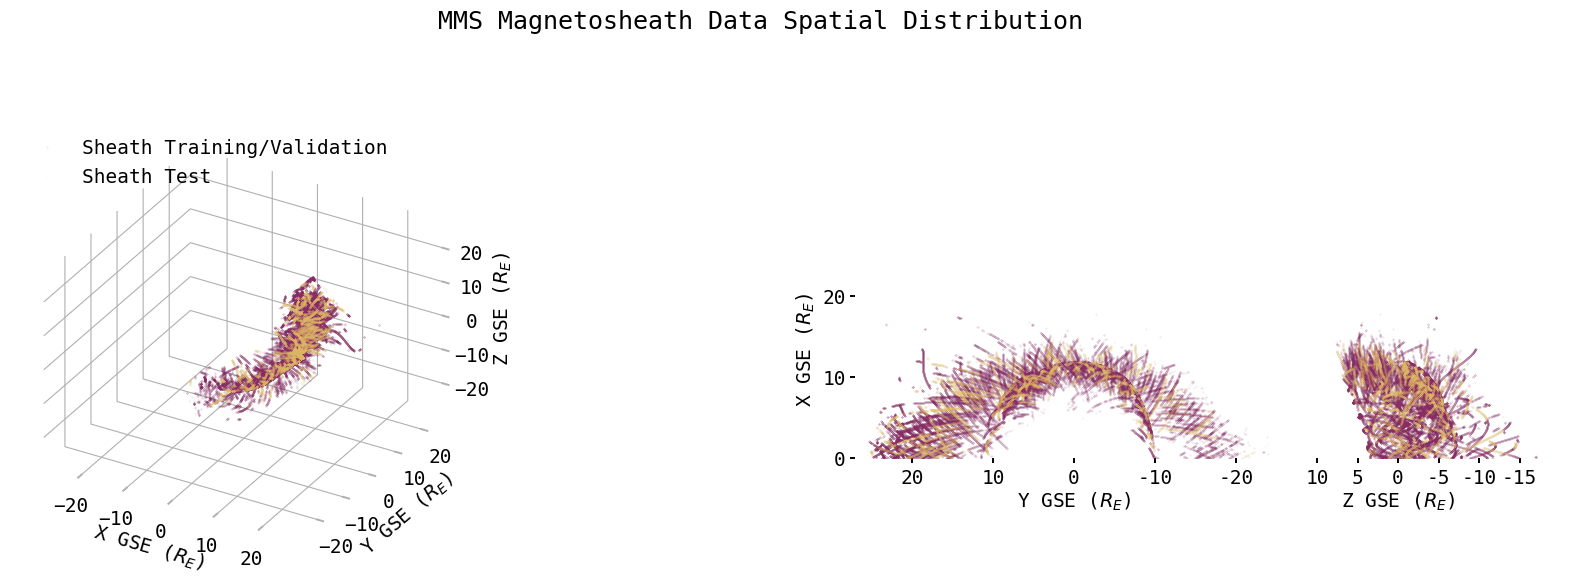

In [3]:
#Plot the MMS solar wind data in 3D
fig = plt.figure(figsize=(20,7))
fig.suptitle('MMS Magnetosheath Data Spatial Distribution', fontsize = 18)
ax = fig.add_subplot(131, projection='3d')
ax.plot(mms_train['R_xgse'], mms_train['R_ygse'], mms_train['R_zgse'], '.', markersize = 0.5, c = c1, label = 'Sheath Training/Validation', alpha = 0.2)
ax.plot(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', markersize = 0.5, c = c5, label = 'Sheath Test', alpha = 0.2)
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='x', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='y', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='z', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)
ax.legend(fontsize = 14, loc = 'upper left')

ax2 = fig.add_subplot(122)
ax2.plot(mms_train['R_ygse'], mms_train['R_xgse'], '.', c = c1, markersize = 0.5, alpha = 0.2)
ax2.plot(mms_test['R_ygse'], mms_test['R_xgse'], '.', c = c5, markersize = 0.5, alpha = 0.2)
#Plot Z and X data 40RE to the right
ax2.plot(mms_train['R_zgse']-40, mms_train['R_xgse'], '.', c = c1, markersize = 0.5, alpha = 0.2)
ax2.plot(mms_test['R_zgse']-40, mms_test['R_xgse'], '.', c = c5, markersize = 0.5, alpha = 0.2)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)')
ax2.set_xlim(27, -60)
ax2.set_xticks([20, 10, 0, -10, -20, -30, -35, -40, -45, -50, -55],
                labels = ['20', '10', '0\nY GSE ($R_{E}$)', '-10', '-20', '10', '5', '0\nZ GSE ($R_{E}$)', '-5', '-10', '-15'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

#plt.savefig('./plots/mms_sw_3d_test.png', bbox_inches = 'tight', dpi = 300)
print(len(mms_sh))

In [4]:
#Calculate the CRPS for each parameter
def crps_func(mu, sg, y):
    ep = np.abs(y - mu)
    crps = sg * ((ep/sg) * errorfunc(ep/(np.sqrt(2)*sg)) + np.sqrt(2/np.pi) * np.exp(-ep**2 / (2*sg**2)) - 1/np.sqrt(np.pi))
    return crps

def crps_min_f(mu, y):
    '''
    Helper function that calculates min continuous rank probability scores
    '''
    ep = np.abs(y - mu)
    N = len(ep)
    crps_min = (np.sqrt(np.log(4.0))/(2*N)) * np.sum(ep)
    return crps_min

mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
mms_sh['pdyn'] = sw.pdyn(mms_sh['Ni'], mms_sh['Vi_xgse'])
predict_test['pdyn'] = sw.pdyn(predict_test['Ni'], predict_test['Vi_xgse'])
predict_test['pdyn_sig'] = sw.pdyn_err(predict_test['Ni'], predict_test['Vi_xgse'], predict_test['Ni_sig'], predict_test['Vi_xgse_sig'])
prime_sw['pdyn'] = sw.pdyn(prime_sw['Ne'], prime_sw['Vi_xgse'])
prime_sw['pdyn_sig'] = sw.pdyn_err(prime_sw['Ne'], prime_sw['Vi_xgse'], prime_sw['Ne_sig'], prime_sw['Vi_xgse_sig'])
mms_test['B'] = np.sqrt(mms_test['B_ygsm']**2 + mms_test['B_zgsm']**2)
predict_test['B'] = np.sqrt(predict_test['B_ygsm']**2 + predict_test['B_zgsm']**2)
predict_test['B_sig'] = sw.mag_err(0, 0, predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig'])
prime_sw['B'] = np.sqrt(prime_sw['B_ygsm']**2 + prime_sw['B_zgsm']**2)
prime_sw['B_sig'] = sw.mag_err(0, 0, prime_sw['B_ygsm'], prime_sw['B_ygsm_sig'], prime_sw['B_zgsm'], prime_sw['B_zgsm_sig'])
mms_test['theta'] = np.arctan2(mms_test['B_ygsm'], mms_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the MMS data
predict_test['theta'] = np.arctan2(predict_test['B_ygsm'], predict_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted data
predict_test['theta_sig'] = sw.theta_err(predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted data
prime_sw['theta'] = np.arctan2(prime_sw['B_ygsm'], prime_sw['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted SW data
prime_sw['theta_sig'] = sw.theta_err(prime_sw['B_ygsm'], prime_sw['B_ygsm_sig'], prime_sw['B_zgsm'], prime_sw['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted SW data

keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tiperp', 'Tipar', 'pdyn'] #Keys for the data parameters to be compared
keys_sig = [key+'_sig' for key in keys]
labels = ['Bx (nT)', 'By (nT)', 'Bz (nT)', 'Vx (km/s)', 'Vy (km/s)', 'Vz (km/s)', '$n_{i}$ (cm$^{-3}$)', '$P_{dyn}$ (nPa)'] #Labels for the data parameters to be compared
predict_error = crps_func(predict_test[keys], predict_test[keys_sig].to_numpy(), mms_test[keys]) #Calculate the CRPS between the predicted and mms test sets
predict_error_min = crps_min_f(predict_test[keys], mms_test[keys]) #Calculate the minimum possible CRPS between the predicted and mms test sets
predict_error['Epoch'] = pd.to_datetime(mms_test['Epoch'], unit='s', utc=True) #Add the time column back in
predicted_mae = np.mean(np.abs(predict_test[keys] - mms_test[keys]), axis = 0)/np.std(mms_train[keys])
print('PRIME CRPS:\n', np.mean(np.abs(predict_error[keys])/np.std(mms_train[keys]), axis = 0)) #Print the CRPS for each parameter
print('PRIME Min CRPS:\n', predict_error_min) #Print the minimal CRPS for each parameter
print('PRIME MAE:\n', predicted_mae) #Print the MAE for each parameter

/tmp/ipykernel_271/1207962046.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
/tmp/ipykernel_271/1207962046.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
/tmp/ipykernel_271/1207962046.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

PRIME CRPS:
 B_xgsm     0.296078
B_ygsm     0.244875
B_zgsm     0.322637
Vi_xgse    0.182287
Vi_ygse    0.127393
Vi_zgse    0.291288
Ni         0.169173
Tiperp     0.157746
Tipar      0.197764
pdyn       0.224674
dtype: float64
PRIME Min CRPS:
 B_xgsm      2.125930
B_ygsm      3.326698
B_zgsm      4.166992
Vi_xgse    11.334343
Vi_ygse    10.570364
Vi_zgse    12.392163
Ni          2.919076
Tiperp     19.181372
Tipar      18.077986
pdyn        0.207991
dtype: float64
PRIME MAE:
 B_xgsm     0.403122
B_ygsm     0.330924
B_zgsm     0.440136
Vi_xgse    0.250131
Vi_ygse    0.172938
Vi_zgse    0.399281
Ni         0.231071
Tiperp     0.216318
Tipar      0.267826
pdyn       0.310726
dtype: float64


In [5]:
#Load outputs from a parameterized version of OpenGGCM (MHD model)
mhd_outputs = pd.read_csv('./data/mhd_outputs.csv')
mhd_outputs['time'] = pd.to_datetime(mhd_outputs['time'], format = '%Y-%m-%d %H:%M:%S%z')
mhd_outputs.dropna(inplace = True)
mhd_outputs_test_index = ksc.closest_argmin(mms_test['Epoch'].to_numpy(), mhd_outputs['time'].to_numpy()) #Get the indices of the MHD outputs closest to each entry in mms_test
mhd_outputs_test = mhd_outputs.iloc[mhd_outputs_test_index] #Select the MHD outputs that correspond to the test set
mhd_outputs_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
mhd_outputs_test = mhd_outputs_test.rename(columns = {'time':'Epoch', 'Bx':'B_xgsm', 'By':'B_ygsm', 'Bz':'B_zgsm', 'Vx':'Vi_xgse', 'Vy':'Vi_ygse', 'Vz':'Vi_zgse', 'n':'Ni', 'Tev':'Tiperp'})
mhd_outputs_test['pdyn'] = sw.pdyn(mhd_outputs_test['Ni'], mhd_outputs_test['Vi_xgse'])
mhd_outputs_test['Tipar'] = mhd_outputs_test['Tiperp'] #Assume isotropic temperature
mhd_outputs_test['Vi_ygse'] += 30 #Correct for Earth's motion
#Drop entries in mhd_outputs_test with an Epoch more than 100s away from the nearest MMS entry Epoch
mhd_outputs_test = mhd_outputs_test.loc[np.abs(mhd_outputs_test['Epoch'] - mhd_outputs_test['Epoch'].shift(1)).dt.total_seconds() < 100, :]
#Drop duplicate entries
mhd_outputs_test = mhd_outputs_test.drop_duplicates(keep='first')

#Load outputs from Soucek and Escoubet model
soucek_outputs = pd.read_csv('./data/soucek_outputs.csv')
soucek_outputs['time'] = pd.to_datetime(soucek_outputs['time'], format = '%Y-%m-%d %H:%M:%S%z')
soucek_outputs.dropna(inplace = True)
soucek_outputs_test_index = ksc.closest_argmin(mms_test['Epoch'].to_numpy(), soucek_outputs['time'].to_numpy()) #Get the indices of the MHD outputs closest to each entry in mms_test
soucek_outputs_test = soucek_outputs.iloc[soucek_outputs_test_index] #Select the MHD outputs that correspond to the test set
soucek_outputs_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
soucek_outputs_test = soucek_outputs_test.rename(columns = {'time':'Epoch', 'vx':'Vi_xgse', 'vy':'Vi_ygse', 'vz':'Vi_zgse'})
#Drop entries in soucek_outputs_test with an Epoch more than 100s away from the nearest MMS entry Epoch
soucek_outputs_test = soucek_outputs_test.loc[np.abs(soucek_outputs_test['Epoch'] - soucek_outputs_test['Epoch'].shift(1)).dt.total_seconds() < 100, :]
#Drop duplicate entries
soucek_outputs_test = soucek_outputs_test.drop_duplicates(keep='first')

#Load outputs from the Spreiter model
spreiter_outputs = pd.read_csv('./data/spreiter_outputs.csv')
spreiter_outputs['time'] = pd.to_datetime(spreiter_outputs['time'], format = '%Y-%m-%d %H:%M:%S%z')
spreiter_outputs.dropna(inplace = True)
spreiter_outputs_test_index = ksc.closest_argmin(mms_test['Epoch'].to_numpy(), spreiter_outputs['time'].to_numpy()) #Get the indices of the MHD outputs closest to each entry in mms_test
spreiter_outputs_test = spreiter_outputs.iloc[spreiter_outputs_test_index] #Select the MHD outputs that correspond to the test set
spreiter_outputs_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
spreiter_outputs_test = spreiter_outputs_test.rename(columns = {'time':'Epoch', 'n':'Ni', 'Tev':'Tipar'})
spreiter_outputs_test['pdyn'] = sw.pdyn(spreiter_outputs_test['Ni'], spreiter_outputs_test['V'])
spreiter_outputs_test['Tipar'] *= 5 #Temperature correction factor (is this because of units?)
spreiter_outputs_test['Tiperp'] = spreiter_outputs_test['Tipar'] #Assume isotropic temperature
#Drop entries in spreiter_outputs_test with an Epoch more than 100s away from the nearest MMS entry Epoch
spreiter_outputs_test = spreiter_outputs_test.loc[np.abs(spreiter_outputs_test['Epoch'] - spreiter_outputs_test['Epoch'].shift(1)).dt.total_seconds() < 100, :]
#Drop duplicate entries
spreiter_outputs_test = spreiter_outputs_test.drop_duplicates(keep='first')

#Use the Cooling magnetosheath field model to get comparison field
def cooling_imf(b_imf, pdyn, pos):
    '''
    Returns the magnetosheath B field vector in GSM coordinates at the position of the spacecraft.
    Cooling JGR 2001 Model, equation 9 to 12

    Parameters:
        b_imf (list): IMF vector in GSM coordinates (minutely)
        pdyn (float): Solar wind dynamic pressure (minutely)
        pos (list): Position of the spacecraft in GSM coordinates
    Returns:
        b_ms (list): Magnetosheath B field vector in GSM coordinates at the position of the spacecraft
    '''
    rmp = (10.22 + 1.29*np.tanh(0.184*(b_imf[:,2] + 8.14)))*(pdyn**(-1/6.6)) #Magnetopause radius from Shue et al. 1998
    A = 2
    ll = 3 * rmp/2 - pos[:,0]
    b_msx = - A * (- b_imf[:,0] * (1 - rmp / (2 * ll)) + b_imf[:,1]
                * (pos[:,1] / ll) + b_imf[:,2] * (pos[:,2] / ll))
    b_msy = A * (- b_imf[:,0] * (pos[:,1] / (2 * ll)) + b_imf[:,1]
                * (2 - pos[:,1]**2/( ll * rmp)) - b_imf[:,2] * (pos[:,1] * pos[:,2] / (ll * rmp)))
    b_msz = A * (- b_imf[:,0] * (pos[:,2] / (2 * ll)) - b_imf[:,1]
                * (pos[:,1] * pos[:,2] / (ll * rmp)) + b_imf[:,2] * (2 - pos[:,2]**2 / (ll * rmp)))
    b_ms = np.array([b_msx, b_msy, b_msz])
    return b_ms
omni_bs = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_bs', mode = 'a') #load shifted omni data
omni_bs_cooling = omni_bs.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_bs['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
omni_bs_cooling.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])
b_ms = cooling_imf(omni_bs_cooling[['B_xgsm', 'B_ygsm', 'B_zgsm']].to_numpy(), omni_bs_cooling['pdyn'].to_numpy(), mms_test[['R_xgse', 'R_ygse', 'R_zgse']].to_numpy())
b_ms = pd.DataFrame(b_ms.T, columns = ['B_xgsm', 'B_ygsm', 'B_zgsm'], index = mms_test.index)
b_ms['Epoch'] = mms_test['Epoch']
b_ms['B'] = np.sqrt(b_ms['B_ygsm']**2 + b_ms['B_zgsm']**2)
b_ms['theta'] = np.arctan2(b_ms['B_ygsm'], b_ms['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the Cooling model generated field
b_ms.index = mms_test.index

/tmp/ipykernel_8049/1425033594.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
/tmp/ipykernel_8049/1425033594.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])


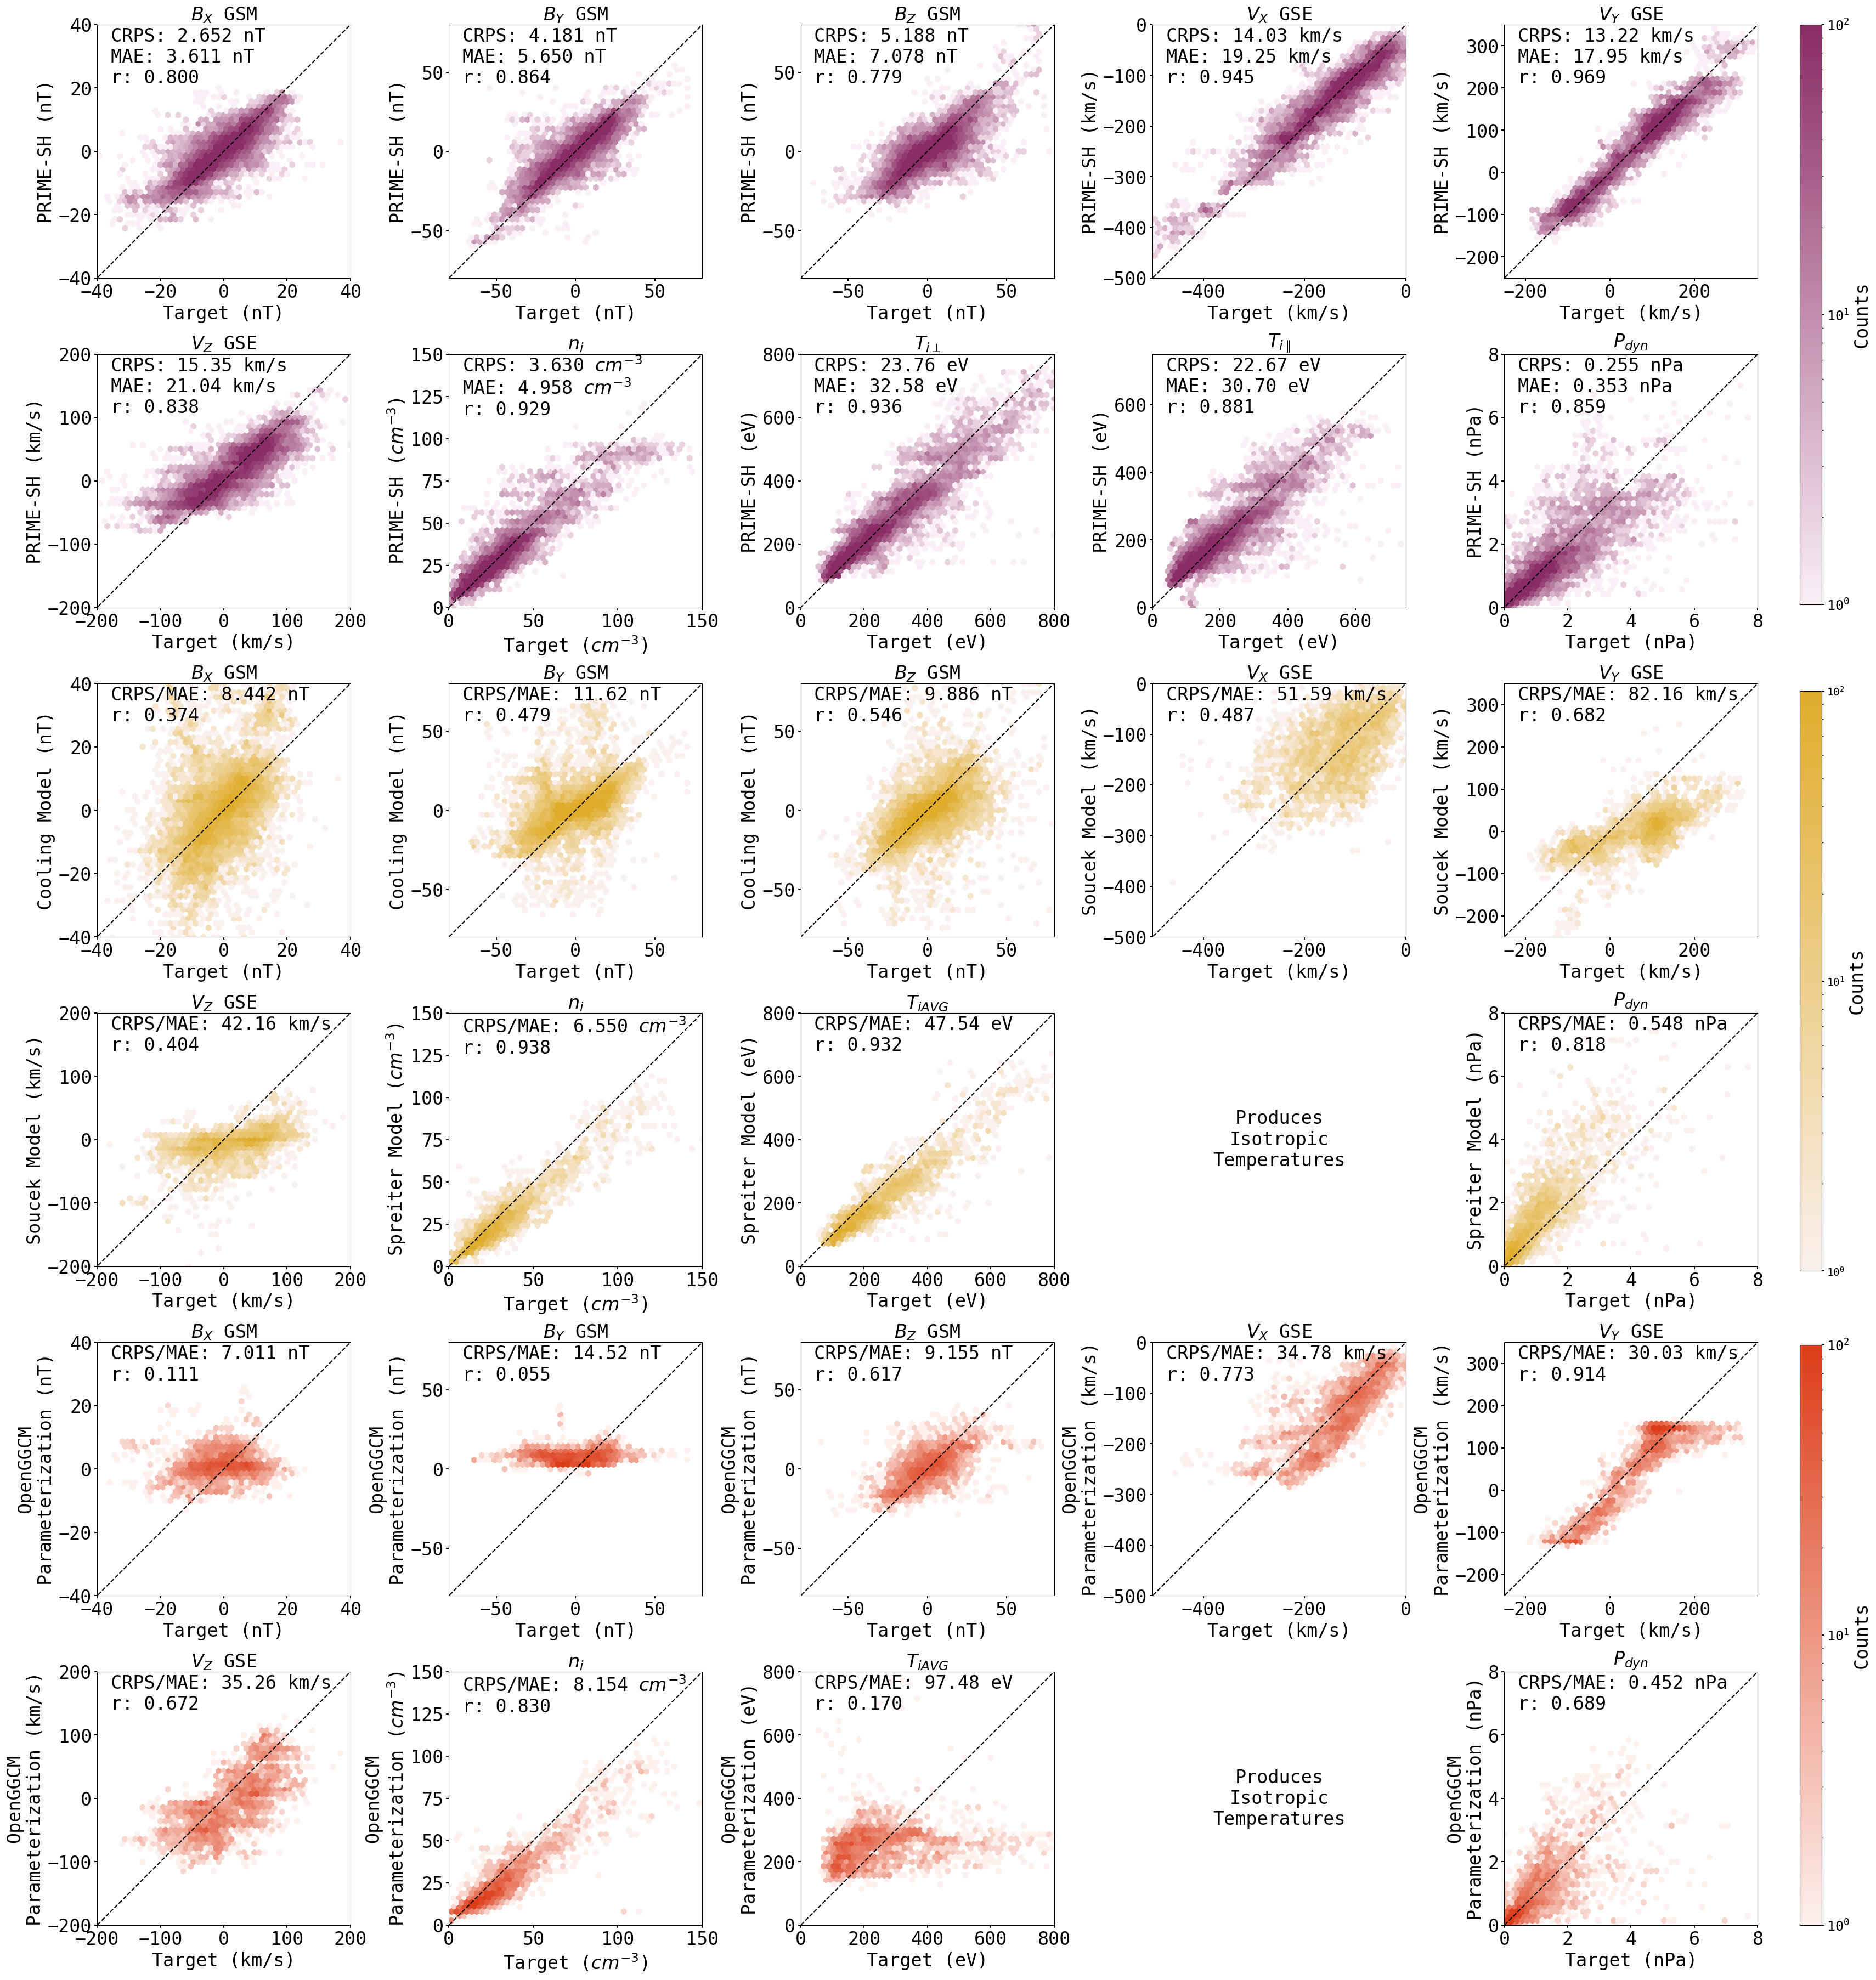

In [6]:
#Plot joint distributions for MHD, analytical models, and PRIME-SH
nbins = 50
keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tiperp', 'Tipar', 'pdyn'] #Keys for the data parameters to be compared
bounds = [[-40, 40], [-80, 80], [-80, 80], [-500, 0], [-250, 350], [-200, 200],[0,150],[0,800],[0,750],[0,8]]
titles = [r'$B_{X}$ GSM',r'$B_{Y}$ GSM',r'$B_{Z}$ GSM',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE', '$n_{i}$', r'$T_{i\perp}$', r'$T_{i\parallel}$', r'$P_{dyn}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$','eV', 'eV', 'nPa']
nrows = 6
ncols = 5
textsize = 24
fig, ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(40, 45)
plt.subplots_adjust(hspace = 0.3, wspace=0.2)

for idx, key in enumerate(keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx//ncols,idx%ncols].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[idx//ncols,idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)
    ax[idx//ncols,idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//ncols,idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//ncols,idx%ncols].set_aspect('equal')
    ax[idx//ncols,idx%ncols].set_xlabel('Target ('+units[idx]+')', fontsize = textsize)
    ax[idx//ncols,idx%ncols].set_ylabel('PRIME-SH ('+units[idx]+')', fontsize = textsize)
    ax[idx//ncols,idx%ncols].set_title(titles[idx], fontsize = textsize)
    ax[idx//ncols,idx%ncols].autoscale(enable=False)
    ax[idx//ncols,idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx//ncols,idx%ncols].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols,idx%ncols].transAxes, color = 'k', fontsize = textsize)
    
    #Soucek, Cooling in the middle third
    if (idx==0)|(idx==1)|(idx==2): #Cooling outputs Bx, By, and Bz
        pred_temp = b_ms[key]
        pred_temp.where((pred_temp < mms_test[key].max())&(pred_temp > mms_test[key].min()), np.nan, inplace = True)
        pred_temp = pred_temp.dropna()
        mms_temp = mms_test[key][pred_temp.index]
        bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
        im2 = ax[idx//ncols+(nrows//3),idx%ncols].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_yellows)
        ax[idx//ncols+(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
        ax[idx//ncols+(nrows//3),idx%ncols].set_aspect('equal')
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlabel('Target ('+units[idx]+')', fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylabel('Cooling Model ('+units[idx]+')', fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].set_title(titles[idx], fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].autoscale(enable=False)
        ax[idx//ncols+(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
        model_mae = np.mean(np.abs(pred_temp - mms_temp))
        model_r, model_p = sps.pearsonr(pred_temp, mms_temp)
        ax[idx//ncols+(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
    elif (idx==3)|(idx==4)|(idx==5): #Soucek outputs Vx, Vy, and Vz
        bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
        im2 = ax[idx//ncols+(nrows//3),idx%ncols].hexbin(mms_test.loc[soucek_outputs_test.index, key], soucek_outputs_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_yellows)
        ax[idx//ncols+(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
        ax[idx//ncols+(nrows//3),idx%ncols].set_aspect('equal')
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlabel('Target ('+units[idx]+')', fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylabel('Soucek Model ('+units[idx]+')', fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].set_title(titles[idx], fontsize = textsize)
        ax[idx//ncols+(nrows//3),idx%ncols].autoscale(enable=False)
        ax[idx//ncols+(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
        model_mae = np.mean(np.abs(soucek_outputs_test[key] - mms_test.loc[soucek_outputs_test.index, key]))
        model_r, model_p = sps.pearsonr(soucek_outputs_test[key], mms_test.loc[soucek_outputs_test.index, key])
        ax[idx//ncols+(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
    elif (idx==6)|(idx==7)|(idx==9)|(idx==9): #Spreiter outputs Ni, Tiav, and pdyn
        bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
        if (idx==7): #Tav
            t_av = (1/3)*(2*mms_test.loc[spreiter_outputs_test.index, 'Tiperp']+mms_test.loc[spreiter_outputs_test.index, 'Tipar']) #Calculate the average temperature
            im2 = ax[idx//ncols+(nrows//3),idx%ncols].hexbin(t_av, spreiter_outputs_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_yellows)
            ax[idx//ncols+(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
            ax[idx//ncols+(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+(nrows//3),idx%ncols].set_aspect('equal')
            ax[idx//ncols+(nrows//3),idx%ncols].set_xlabel('Target (eV)', fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].set_ylabel('Spreiter Model (eV)', fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].set_title(r'$T_{i AVG}$', fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].autoscale(enable=False)
            ax[idx//ncols+(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
            model_mae = np.mean(np.abs(spreiter_outputs_test[key] - t_av))
            model_r, model_p = sps.pearsonr(spreiter_outputs_test[key], t_av)
            ax[idx//ncols+(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
        else:
            im2 = ax[idx//ncols+(nrows//3),idx%ncols].hexbin(mms_test.loc[spreiter_outputs_test.index, key], spreiter_outputs_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_yellows)
            ax[idx//ncols+(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
            ax[idx//ncols+(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+(nrows//3),idx%ncols].set_aspect('equal')
            ax[idx//ncols+(nrows//3),idx%ncols].set_xlabel('Target ('+units[idx]+')', fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].set_ylabel('Spreiter Model ('+units[idx]+')', fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].set_title(titles[idx], fontsize = textsize)
            ax[idx//ncols+(nrows//3),idx%ncols].autoscale(enable=False)
            ax[idx//ncols+(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
            model_mae = np.mean(np.abs(spreiter_outputs_test[key] - mms_test.loc[spreiter_outputs_test.index, key]))
            model_r, model_p = sps.pearsonr(spreiter_outputs_test[key], mms_test.loc[spreiter_outputs_test.index, key])
            ax[idx//ncols+(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
    else: #If the models cant produce a parameter, clear the spines to leave a blank space
        ax[idx//ncols+(nrows//3),idx%ncols].spines['top'].set_visible(False)
        ax[idx//ncols+(nrows//3),idx%ncols].spines['right'].set_visible(False)
        ax[idx//ncols+(nrows//3),idx%ncols].spines['bottom'].set_visible(False)
        ax[idx//ncols+(nrows//3),idx%ncols].spines['left'].set_visible(False)
        ax[idx//ncols+(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = 18, color = 'white')
        ax[idx//ncols+(nrows//3),idx%ncols].set_xticks([])
        ax[idx//ncols+(nrows//3),idx%ncols].set_yticks([])
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlim(0,1)
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylim(0,1)
        ax[idx//ncols+(nrows//3),idx%ncols].set_aspect('equal')
        ax[idx//ncols+(nrows//3),idx%ncols].set_xlabel('')
        ax[idx//ncols+(nrows//3),idx%ncols].set_ylabel('')
        ax[idx//ncols+(nrows//3),idx%ncols].set_title('')
        ax[idx//ncols+(nrows//3),idx%ncols].text(.5, .5, 'Produces\nIsotropic\nTemperatures', ha='center', va='center', transform = ax[idx//ncols+(nrows//3),idx%ncols].transAxes, color = 'Black', fontsize = textsize)
    #MHD in the bottom third
    if (idx!=8): #MHD can't produce Tipar
        bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
        if (idx==7): #Tav
            t_av = (1/3)*(2*mms_test.loc[mhd_outputs_test.index, 'Tiperp']+mms_test.loc[mhd_outputs_test.index, 'Tipar']) #Calculate the average temperature
            im3 = ax[idx//ncols+2*(nrows//3),idx%ncols].hexbin(t_av, mhd_outputs_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
            ax[idx//ncols+2*(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_aspect('equal')
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlabel('Target (eV)', fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylabel('OpenGGCM\nParameterization (eV)', fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_title(r'$T_{i AVG}$', fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].autoscale(enable=False)
            ax[idx//ncols+2*(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
            model_mae = np.mean(np.abs(mhd_outputs_test[key] - t_av))
            model_r, model_p = sps.pearsonr(mhd_outputs_test[key], t_av)
            ax[idx//ncols+2*(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+2*(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
        else:
            im3 = ax[idx//ncols+2*(nrows//3),idx%ncols].hexbin(mms_test.loc[mhd_outputs_test.index, key], mhd_outputs_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
            ax[idx//ncols+2*(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = textsize)  
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylim(bounds[idx][0], bounds[idx][1])
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_aspect('equal')
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlabel('Target ('+units[idx]+')', fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylabel('OpenGGCM\nParameterization ('+units[idx]+')', fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].set_title(titles[idx], fontsize = textsize)
            ax[idx//ncols+2*(nrows//3),idx%ncols].autoscale(enable=False)
            ax[idx//ncols+2*(nrows//3),idx%ncols].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
            model_mae = np.mean(np.abs(mhd_outputs_test[key] - mms_test.loc[mhd_outputs_test.index, key]))
            model_r, model_p = sps.pearsonr(mhd_outputs_test[key], mms_test.loc[mhd_outputs_test.index, key])
            ax[idx//ncols+2*(nrows//3),idx%ncols].text(.01, .99, ' CRPS/MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//ncols+2*(nrows//3),idx%ncols].transAxes, color = 'k', fontsize = textsize)
    else: #If the MHD model cant produce a parameter, clear the spines to leave a blank space
        ax[idx//ncols+2*(nrows//3),idx%ncols].spines['top'].set_visible(False)
        ax[idx//ncols+2*(nrows//3),idx%ncols].spines['right'].set_visible(False)
        ax[idx//ncols+2*(nrows//3),idx%ncols].spines['bottom'].set_visible(False)
        ax[idx//ncols+2*(nrows//3),idx%ncols].spines['left'].set_visible(False)
        ax[idx//ncols+2*(nrows//3),idx%ncols].tick_params(axis='both', which='major', labelsize = 18, color = 'white')
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_xticks([])
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_yticks([])
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlim(0,1)
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylim(0,1)
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_aspect('equal')
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_xlabel('')
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_ylabel('')
        ax[idx//ncols+2*(nrows//3),idx%ncols].set_title('')
        ax[idx//ncols+2*(nrows//3),idx%ncols].text(.5, .5, 'Produces\nIsotropic\nTemperatures', ha='center', va='center', transform = ax[idx//ncols+2*(nrows//3),idx%ncols].transAxes, color = 'Black', fontsize = textsize)
#Put colorbar for im1 on the right top third of the rows
cbar_ax = fig.add_axes([0.91, 0.645, 0.01, 0.235])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = textsize)
cbar.ax.tick_params(labelsize=18)
#Put colorbar for im2 on the middle third
cbar_ax = fig.add_axes([0.91, 0.375, 0.01, 0.235])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Counts', fontsize = textsize)
#Put colorbar for im3 on the bottom third
cbar_ax = fig.add_axes([0.91, 0.110, 0.01, 0.235])
cbar = fig.colorbar(im3, cax=cbar_ax)
cbar.set_label('Counts', fontsize = textsize)
cbar.ax.tick_params(labelsize=18)
#plt.savefig('./plots/prime_mhd_analytical_jd.png', bbox_inches='tight', dpi=150)

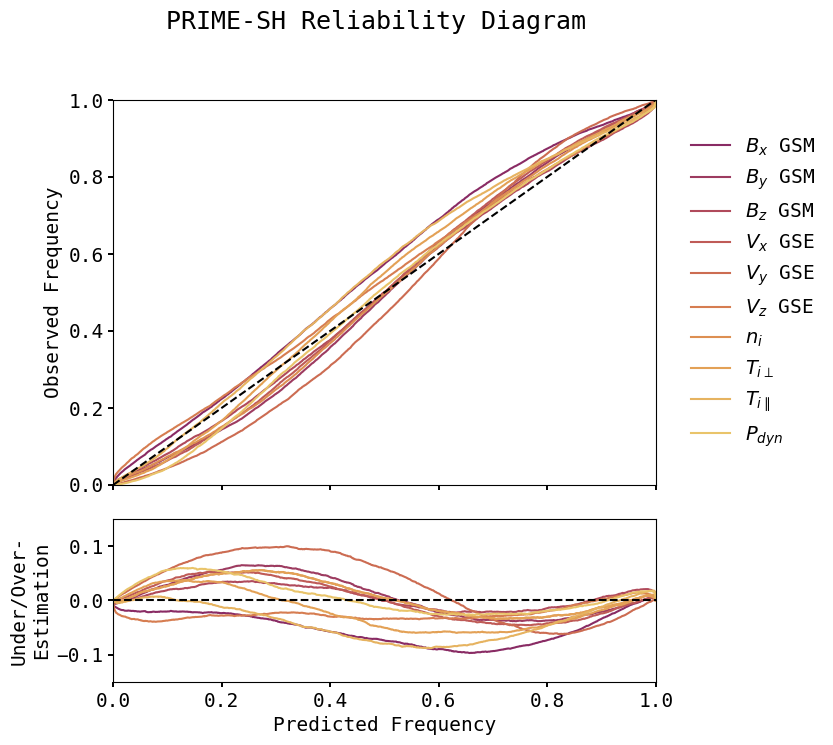

In [7]:
#Reliability diagram
standard_err = (mms_test[keys] - predict_test[keys])/(np.sqrt(2) * predict_test[keys_sig].to_numpy()) #Standard error for each parameter
phi = np.linspace(0,1,1000) #Predicted probability axis
cumulative_dist = np.zeros((len(phi), len(keys))) #Cumulative distribution for each parameter
for idx, key in enumerate(keys):
    for i in standard_err[key].index:
        cumulative_dist[:,idx] += (1/len(standard_err[key])) * np.heaviside(phi - 0.5*(errorfunc(standard_err.loc[i,key])+1) , 1) #Calculate the cumulative distribution for each parameter
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7,9))
color_arr = primesh_cmap(np.linspace(0,1,10)) #Color array for each parameter
ax[0].plot(phi, cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[0].plot(phi, cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[0].plot(phi, cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[0].plot(phi, cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[0].plot(phi, cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[0].plot(phi, cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[0].plot(phi, cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[0].plot(phi, cumulative_dist[:,7], label = r'$T_{i\perp}$', c = color_arr[7])
ax[0].plot(phi, cumulative_dist[:,8], label = r'$T_{i\parallel}$', c = color_arr[8])
ax[0].plot(phi, cumulative_dist[:,9], label = r'$P_{dyn}$', c = color_arr[9])
#Place legend in the outside right middle of the figure
ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax[0].plot(phi, phi, linestyle = '--', color = 'k')
ax[0].set_ylabel('Observed Frequency')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
fig.suptitle('PRIME-SH Reliability Diagram', fontsize = 18)

ax[1].plot(phi, phi - cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[1].plot(phi, phi - cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[1].plot(phi, phi - cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[1].plot(phi, phi - cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[1].plot(phi, phi - cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[1].plot(phi, phi - cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = r'$T_{i\perp}$', c = color_arr[7])
ax[1].plot(phi, phi - cumulative_dist[:,7], label = r'$T_{i\perp}$', c = color_arr[7])
ax[1].plot(phi, phi - cumulative_dist[:,8], label = r'$T_{i\parallel}$', c = color_arr[8])
ax[1].plot(phi, phi - cumulative_dist[:,9], label = r'$P_{dyn}$', c = color_arr[9])
ax[1].plot(phi, np.zeros(len(phi)), linestyle = '--', color = 'k')
ax[1].set_ylim(-0.15,0.15)
ax[1].set_xlabel('Predicted Frequency')
ax[1].set_ylabel('Under/Over-\nEstimation')
ax[1].set_aspect('equal')
plt.subplots_adjust(hspace = -0.20)
#plt.savefig('./plots/reliability_diagram.pdf', bbox_inches='tight')

In [8]:
for i, key in enumerate(keys):
    print('Max deviation from perfect reliability in ', key, ':, ', np.max(np.abs(phi - cumulative_dist[:,i])))
    print('Mean deviation from perfect reliability in ', key, ':, ', np.mean(np.abs(phi - cumulative_dist[:,i])))
    print('Predicted frequency of max deviation: ', phi[np.argmax(np.abs(phi - cumulative_dist[:,i]))], '\nObserved frequency: ', cumulative_dist[np.argmax(np.abs(phi - cumulative_dist[:,i])),i])

Max deviation from perfect reliability in  B_xgsm :,  0.09714619799710689
Mean deviation from perfect reliability in  B_xgsm :,  0.051474250300623414
Predicted frequency of max deviation:  0.6566566566566566 
Observed frequency:  0.7538028546537635
Max deviation from perfect reliability in  B_ygsm :,  0.06489509009111089
Mean deviation from perfect reliability in  B_ygsm :,  0.031631858421388805
Predicted frequency of max deviation:  0.26726726726726724 
Observed frequency:  0.20237217717615635
Max deviation from perfect reliability in  B_zgsm :,  0.03546030785863735
Mean deviation from perfect reliability in  B_zgsm :,  0.01779277863938341
Predicted frequency of max deviation:  0.2552552552552553 
Observed frequency:  0.21979494739661792
Max deviation from perfect reliability in  Vi_xgse :,  0.052185670895045666
Mean deviation from perfect reliability in  Vi_xgse :,  0.030471815982650263
Predicted frequency of max deviation:  0.18118118118118118 
Observed frequency:  0.128995510286135

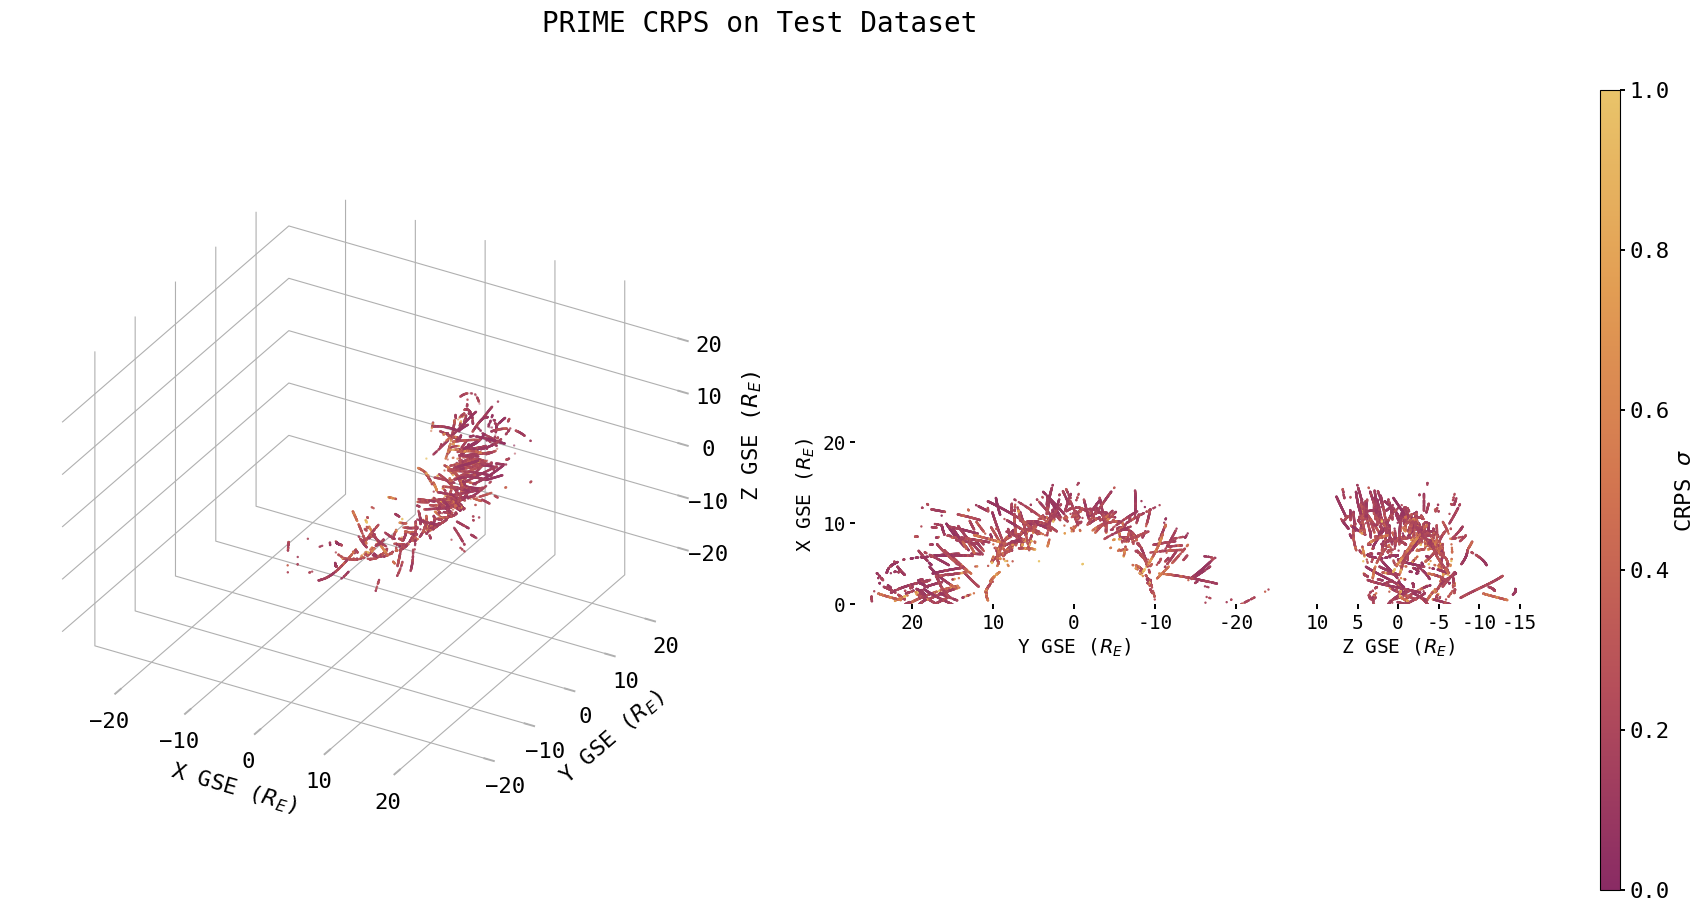

In [9]:
#Plot PRIME's performance (CRPS) in GSE coordinates
fig = plt.figure(figsize=(20,10))
fig.suptitle('PRIME CRPS on Test Dataset', fontsize = 20)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', s = 0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), label = 'SH Test', cmap = primesh_cmap, vmin=0, vmax=1)
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

#ax.plot(wind_data['Px_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Py_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Pz_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, '.', markersize = 0.5, c = c1, label = 'Wind Inputs')
ax.set_xlabel('\nX GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='x', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_ylabel('\nY GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='y', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_zlabel('\nZ GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='z', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)

ax2 = fig.add_subplot(122)
scatter = ax2.scatter(mms_test['R_ygse'], mms_test['R_xgse'], s=0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), cmap = primesh_cmap, vmin=0, vmax=1)
scatter = ax2.scatter(mms_test['R_zgse']-40, mms_test['R_xgse'], s=0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), cmap = primesh_cmap, vmin=0, vmax=1)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)')
ax2.set_xlim(27, -60)
ax2.set_xticks([20, 10, 0, -10, -20, -30, -35, -40, -45, -50, -55],
                labels = ['20', '10', '0\nY GSE ($R_{E}$)', '-10', '-20', '10', '5', '0\nZ GSE ($R_{E}$)', '-5', '-10', '-15'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'CRPS $\sigma$',fontsize = 16)
cbar.ax.tick_params(labelsize=16)  
#plt.savefig('./plots/crps_3d.png', bbox_inches = 'tight', dpi = 300)

In [9]:
#Load dataset hyperparameters
hps = pd.read_hdf(modelpath + 'ds_hyperparameters.h5', key = 'sh_hp_20230822', mode = 'a')
fig = plt.figure(figsize = (7, 7))
dotsize = 2000 #Size of the outer dot
steps = [1/2, 1/6] #Steps for the inner dots
scatter = plt.scatter(hps['window'][hps['fraction']==0.15], hps['stride'][hps['fraction']==0.15], c = hps['val_loss'][hps['fraction']==0.15], s = dotsize, vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.scatter(hps['window'][hps['fraction']==0.10], hps['stride'][hps['fraction']==0.10], c = hps['val_loss'][hps['fraction']==0.10], s = dotsize*steps[0], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.scatter(hps['window'][hps['fraction']==0.05], hps['stride'][hps['fraction']==0.05], c = hps['val_loss'][hps['fraction']==0.05], s = dotsize*steps[1], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.xlabel('Window Size')
plt.xticks(hps['window'].unique())
plt.xlim(hps['window'].unique().min()-2.5, hps['window'].unique().max()+2.5)
plt.ylabel('Stride')
plt.yticks(hps['stride'].unique())
plt.ylim(hps['stride'].unique().min()-1, hps['stride'].unique().max()+1)
plt.title('Magnetosheath Dataset Hyperparameters', fontsize = 18)
#Remove ticks and spines
plt.gca().tick_params(axis='both', which='major', labelsize=14, color = 'white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cbar_ax = fig.add_axes([1.02, 0.4, 0.015, 0.5]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
#cbar.set_ticks([0.19, 0.20, 0.21])
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('CRPS Validation Loss') #Add a label to the colorbar
#plt.savefig(plotpath + 'ds_hyperparameters_20230823.pdf', bbox_inches = 'tight')

KeyError: 'No object named sh_hp_20230822 in the file'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
import prime as pr

primesh = pr.prime() #Create a prime object

In [4]:
#Here we construct a single-point input for PRIME-SH.
#PRIME-SH expects timeseries as input, so we need to construct a timeseries of length "window" with the same input values.

window = primesh.window #Length of timeseries needed for PRIME-SH
stride = primesh.stride #Stride of the timeseries
test_input = pd.DataFrame(columns = primesh.in_keys) #Initialize single-point input dataframe
test_input['B_xgsm'] = 0*np.ones(window) #SW BX in nT (GSM coordinates)
test_input['B_ygsm'] = 0*np.ones(window) #SW BY in nT (GSM coordinates)
test_input['B_zgsm'] = -5*np.ones(window) #SW BZ in nT (GSM coordinates)
test_input['Vi_xgse'] = -400*np.ones(window) #SW X velocity in km/s (GSE coordinates)
test_input['Vi_ygse'] = 0*np.ones(window) #SW Y velocity in km/s
test_input['Vi_zgse'] = 0*np.ones(window) #SW Z velocity in km/s
test_input['Ni'] = 5*np.ones(window) #SW density in cm^-3
test_input['Vth'] = 30*np.ones(window) #SW thermal velocity in km/s
test_input['R_xgse'] = 200*np.ones(window) #Wind position in X GSE (RE)
test_input['R_ygse'] = 0*np.ones(window) #Wind position in Y GSE
test_input['R_zgse'] = 0*np.ones(window) #Wind position in Z GSE

#This is where the location you're propagating to is set.
#Each entry in the "timeseries" is set to the same value, no need to make a fake MMS orbit.
test_input['target_R_xgse'] = 14*np.ones(window) #MMS position in X GSE (RE)
test_input['target_R_ygse'] = 0*np.ones(window) #MMS position in Y GSE
test_input['target_R_zgse'] = 0*np.ones(window) #MMS position in Z GSE

#PRIME-SH also currently expects an 'Epoch' for its inputs. This is helpful for ordering the timeseries, but makes little sense for a single point like we're doing here.
#Here we concoct a window of time that results in a prediction at UNIX timestamp 0.
test_input['Epoch'] = pd.date_range(start='1970-01-01 00:00:00', periods=window, freq='100s') - pd.Timedelta(hours = 2)

#Make one prediction. Predictions are returned as pandas dataframes.
primesh.predict(test_input)

B_xgsm  B_xgsm_sig    B_ygsm  B_ygsm_sig     B_zgsm  B_zgsm_sig  \
0 -0.089818    2.435225  0.410718    5.157336 -18.416056    5.155872   

      Vi_xgse  Vi_xgse_sig    Vi_ygse  Vi_ygse_sig   Vi_zgse  Vi_zgse_sig  \
0 -109.378174    21.546844  72.976334    22.295242  8.952005    18.344069   

          Ni    Ni_sig       Tipar  Tipar_sig      Tiperp  Tiperp_sig  \
0  20.845861  3.947557  206.789124  30.251556  264.681641   36.552399   

       Epoch  
0 1970-01-01

In [7]:
#Here we construct a grid of inputs for PRIME-SH.
gridsize = 0.5 #Size of the grid to calculate the magnetosheath conditions on (RE)
x_extent = [0,20] #Set the GSE X extent of the grid
y_extent = [-30,30] #Set the GSE Y extent of the grid

#This line will calculate the magnetosheath conditions at each point in the grid for one set of solar wind inputs.
sheath_grid_single = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = 1,
                                   bx = 0, by = 0, bz = -5, vx = -400, vy = 0, vz = 0, ni = 5, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic=True)

#For a range of solar wind inputs, specify the inputs as a list, and set framenum to the length of the list.
bz = [-5, 5]
framenum = len(bz)
bx = 0*np.ones(framenum) #Currently, bx, by, bz, and ni must be the same size if specified as a list
by = 0*np.ones(framenum)
ni = 5*np.ones(framenum)
sheath_grid_range = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = 0, by = 0, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic=True)

#Each sheath_grid has shape [framenum, x_grid, y_grid, primesh.tar_keys]

In [ ]:
#Initialize synthetic dataset for four different B orientations

gridsize = 0.1 #Size of the grid to calculate the magnetopause on (RE)
x_extent = [0,20] #Set the GSE X extent of the grid
y_extent = [-30,30] #Set the GSE Y extent of the grid
z_extent = [-5,5] #Set the GSE Z extent of the grid
theta_extent = [-np.pi/2, np.pi/2] #Set the polar angle extent of the grid
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
z_grid = np.arange(z_extent[0], z_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
pdyn = 2 #Placeholder dynamic pressure (nPa)

#Construct frames of different solar wind densities for RH jump conditions
framenum = 4
bx = [5.34, 0, -5.34, 0]
by = [0, 5.34, 0, -5.34]
bz = [5.34, -5.34] #Only two orientations for Bz, specify only in radial_grid_xz
ni = wind_data['Ni'].mean() * np.ones(framenum)

sheath_grid_xy = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = np.zeros(len(bx)), vx = -400, vy = 0, vz = 0, ni = ni, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic=True)
sheath_grid_xz = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, z_extent = z_extent, framenum = 2,
                                      bx = np.zeros(len(bz)), by = np.zeros(len(bz)), bz = bz, vx = -400, vy = 0, vz = 0, ni = ni[0:2], vt = 30,
                                      rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic=True)

/tmp/ipykernel_1647/1971227280.py:3: RuntimeWarning: invalid value encountered in sqrt
  B_xy = np.sqrt(radial_grid_xy[:,:,:,0]**2 + radial_grid_xy[:,:,:,1]**2 + radial_grid_xy[:,:,:,2]**2)
/tmp/ipykernel_1647/1971227280.py:37: RuntimeWarning: invalid value encountered in sqrt
  B_xz = np.sqrt(radial_grid_xz[:,:,:,0]**2 + radial_grid_xz[:,:,:,1]**2 + radial_grid_xz[:,:,:,2]**2)


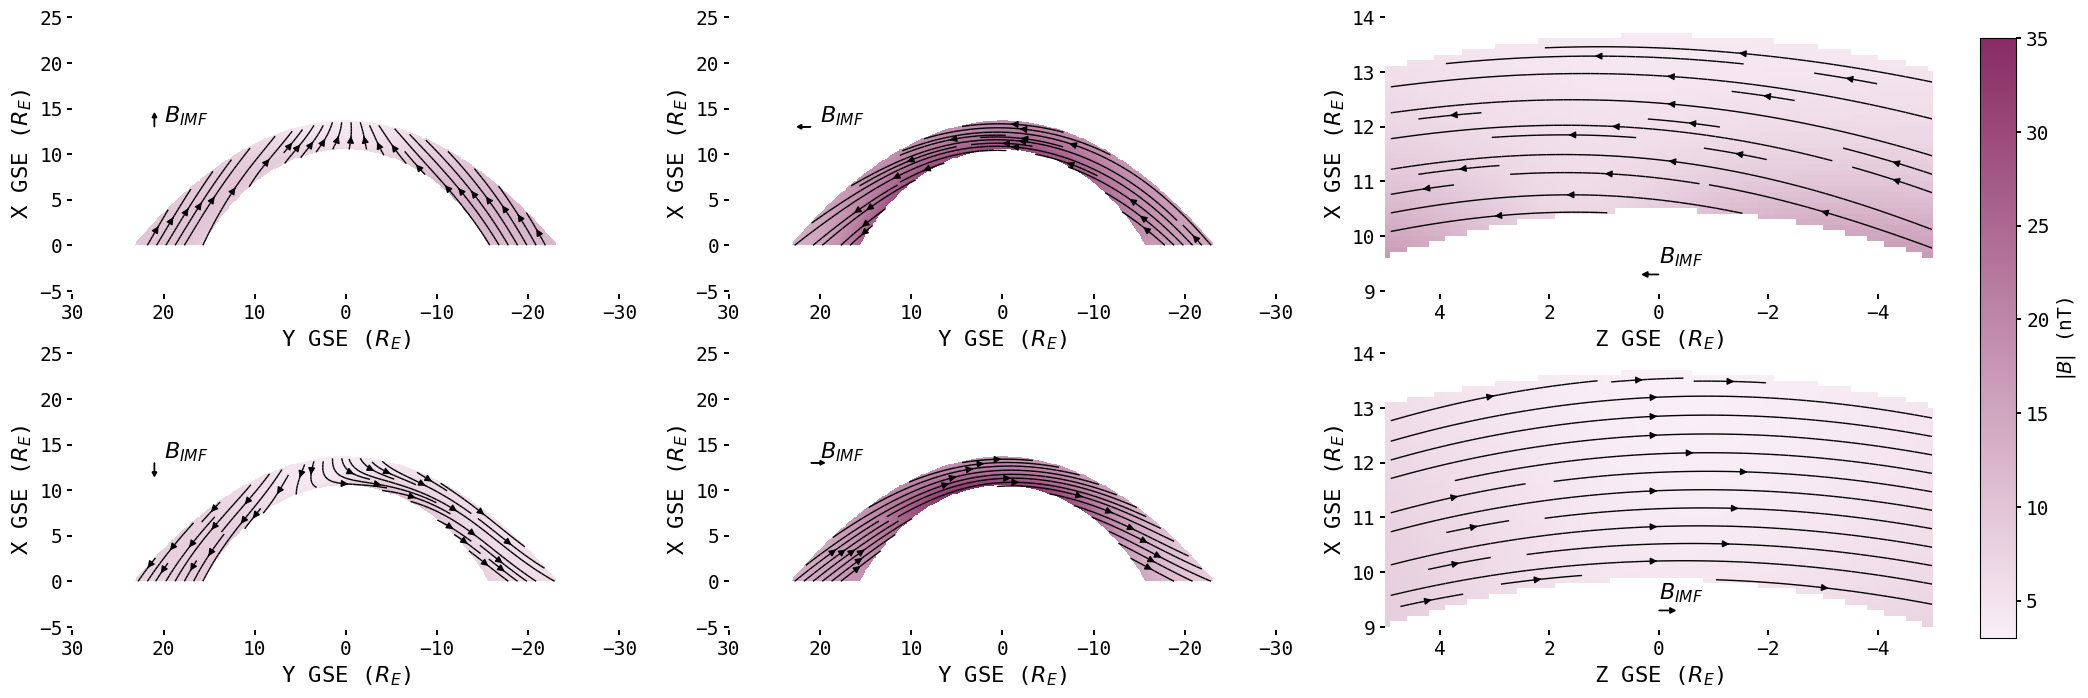

In [16]:
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (24,8))
B_xy = np.sqrt(sheath_grid_xy[:,:,:,0]**2 + sheath_grid_xy[:,:,:,1]**2 + sheath_grid_xy[:,:,:,2]**2)

im, stream, ax2 = pr.streamline(axes[0,0], sheath_grid_xy, x_grid, y_grid, data = B_xy[0,:,:], frame_index = 0, 
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[0]**2 + by[0]**2)
a = axes[0,0].arrow(21, 13, by[0]/b_norm, bx[0]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0,0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[0,1], sheath_grid_xy, x_grid, y_grid, data = B_xy[1,:,:], frame_index = 1,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[1]**2 + by[1]**2)
a = axes[0,1].arrow(21, 13, by[1]/b_norm, bx[1]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0,1].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[1,0], sheath_grid_xy, x_grid, y_grid, data = B_xy[2,:,:], frame_index = 2,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[2]**2 + by[2]**2)
a = axes[1,0].arrow(21, 13, by[2]/b_norm, bx[2]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[1,0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[1,1], sheath_grid_xy, x_grid, y_grid, data = B_xy[3,:,:], frame_index = 3,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[3]**2 + by[3]**2)
a = axes[1,1].arrow(21, 13, by[3]/b_norm, bx[3]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[1,1].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

B_xz = np.sqrt(sheath_grid_xz[:,:,:,0]**2 + sheath_grid_xz[:,:,:,1]**2 + sheath_grid_xz[:,:,:,2]**2)
im, stream, ax2 = pr.streamline(axes[0,2], sheath_grid_xz, x_grid, z_grid, data = B_xz[0,:,:], frame_index = 0,
                                param_index=5, u_index=0, v_index=4, cmap=new_purples,
                                x_extent = x_extent, y_extent = z_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
axes[0,2].set_xlabel(r'Z GSE ($R_{E}$)', fontsize = 16)
axes[0,2].set_ylim(9,14)
stream.lines.axes.set_ylim(9,14)
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bz[0]**2)
a = axes[0,2].arrow(0, 9.3, 0.2*bz[0]/b_norm, 0/b_norm, head_width=0.1, head_length=0.1, fc='k', ec='k') #Add new arrows to the plot
axes[0,2].text(0, 9.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[1,2], sheath_grid_xz, x_grid, z_grid, data = B_xz[1,:,:], frame_index = 1,
                                param_index=5, u_index=0, v_index=4, cmap=new_purples,
                                x_extent = x_extent, y_extent = z_extent, vmin = 3, vmax = 35, draw_streamline = True, linecolor = 'k')
axes[1,2].set_xlabel(r'Z GSE ($R_{E}$)', fontsize = 16)
axes[1,2].set_ylim(9,14)
stream.lines.axes.set_ylim(9,14)
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bz[1]**2)
a = axes[1,2].arrow(0, 9.3, 0.2*bz[1]/b_norm, 0/b_norm, head_width=0.1, head_length=0.1, fc='k', ec='k') #Add new arrows to the plot
axes[1,2].text(0, 9.5, r'$B_{IMF}$', fontsize = 16)

#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, label = '$|B|$ (nT)', box = [0.92, 0.1, 0.015, 0.75])

#plt.savefig(plotpath + 'B_drape.pdf', bbox_inches = 'tight')

In [ ]:
#Construct frames of synthetic alfven mach numbers
x_extent = [0, 20]
y_extent = [-30, 30]
gridsize = 0.1
b_norms = np.array([12, 8, 4.8, 3]) #Range of B magnitudes to use (Results in MA of 4-16)
framenum = len(b_norms)
bx = -1*np.sqrt(2)*b_norms
by = np.sqrt(2)*b_norms
bz = np.zeros(framenum)
ni = 7*np.ones(framenum) #This is a workaround since I haven't added code to check if ni or v are scalar seperately from B yet

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic=True)

/tmp/ipykernel_316/1089646464.py:14: RuntimeWarning: invalid value encountered in sqrt
  arg = np.argmin(np.sqrt(radial_grid[idx, :, :, 6]**2 + radial_grid[idx, :, :, 8]**2))


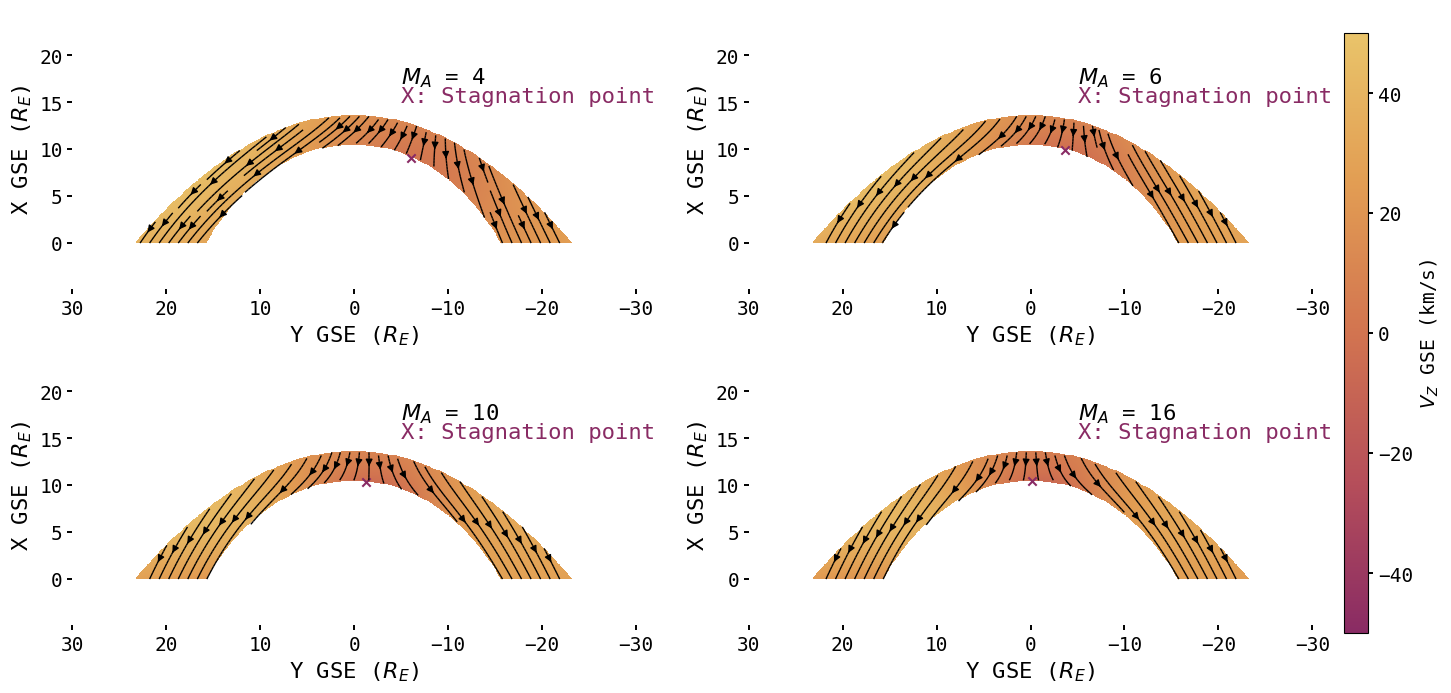

In [80]:
#Plot the Z velocity at each point in the grid for each frame
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,8))
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
for idx, ax in enumerate(axes.flatten()):
    im, stream, ax2 = pr.streamline(ax, radial_grid, x_grid, y_grid, frame_index = idx,
                                    param_index=10, u_index=6, v_index=8, cmap=primesh_cmap,
                                    x_extent = x_extent, y_extent = y_extent, vmin = -50, vmax = 50)
    #Plot the Alfven mach number in the top left of the plot
    ax.text(-5,17, r'$M_{A}$ = ' + str(int(0.0458 * np.abs(-400) * np.sqrt(7) / np.sqrt(b_norms[idx]**2))), fontsize = 16)
    #Add text below alfven mach number with X: Stagnation point in purple
    ax.text(-5,15, 'X: Stagnation point', fontsize = 16, color = c1)
    #Mark the grid cell where normal velocity is minimized
    arg = np.argmin(np.sqrt(radial_grid[idx, :, :, 6]**2 + radial_grid[idx, :, :, 8]**2))
    arg = np.unravel_index(arg, radial_grid[idx, :, :, 6].shape)
    ax.scatter(y_grid[arg[1]], x_grid[arg[0]], color = c1, marker = 'x')
    ax.set_xlim(30, -30)
    ax.set_ylim(0, 20)
#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=10, box = [0.92, 0.1, 0.015, 0.75])
#plt.savefig(plotpath+'sheath_grid_MA.pdf', bbox_inches='tight')

In [15]:
#Construct frames of IMF orientations in the X-Y plane
x_extent = [0, 20]
y_extent = [-30, 30]
gridsize = 0.5
b_angles = np.array([np.pi/4, 0, -1*np.pi/4, np.pi/2, -1*np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4]) #Range of angles of B in the X-Y plane
framenum = len(b_angles)
bx = 5.3*np.cos(b_angles)
by = 5.3*np.sin(b_angles)
bz = np.zeros(framenum)
ni = 5*np.ones(framenum) #This is a workaround since I haven't added code to check if ni or v are scalar seperately from B yet

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic = True)

2024-03-12 10:22:58.050786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 118272000 exceeds 10% of free system memory.


/tmp/ipykernel_316/3586747991.py:14: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(radial_grid[idx,:,:,0]**2+radial_grid[idx,:,:,2]**2+radial_grid[idx,:,:,4]**2) #Calculate the magnitude of the magnetic field
/tmp/ipykernel_316/3586747991.py:31: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(radial_grid[idx-1,:,:,0]**2+radial_grid[idx-1,:,:,2]**2+radial_grid[idx-1,:,:,4]**2)


Text(0.5, 0.5, 'Mirror Mode Wave\nInstability Criterion')

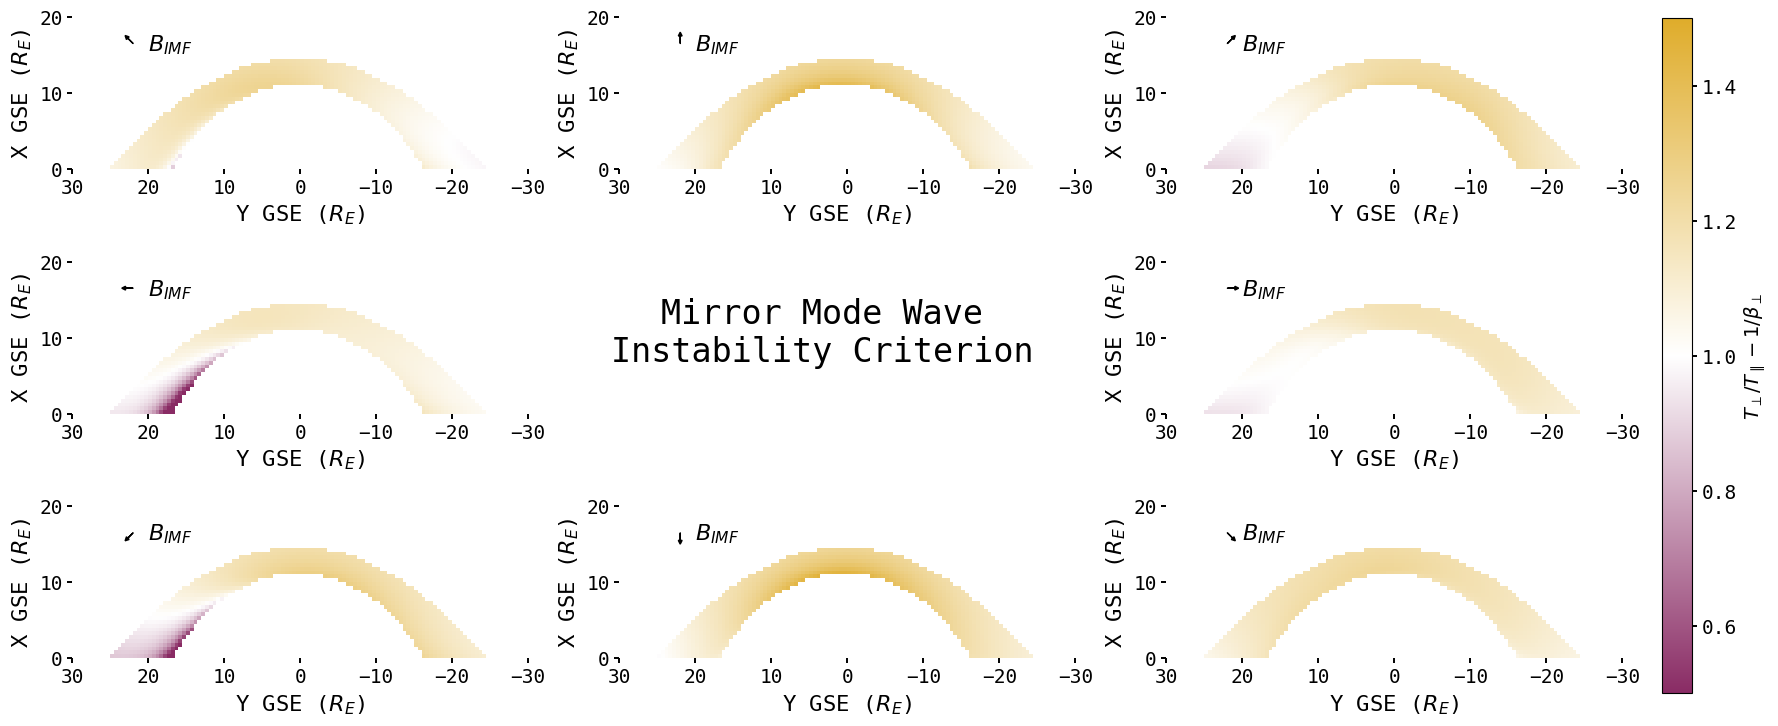

In [16]:
#Plot MM instability criterion for each IMF orientation
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20,9))
for idx, ax in enumerate(axes.flatten()):
    if (idx==4): #Leave the middle plot empty
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize = 18, color = 'white')
        ax.set_xticks([])
        ax.set_yticks([])
    elif(idx<4): #Don't modify idx for the first four plots
        x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
        B = np.sqrt(radial_grid[idx,:,:,0]**2+radial_grid[idx,:,:,2]**2+radial_grid[idx,:,:,4]**2) #Calculate the magnitude of the magnetic field
        beta = 0.403*radial_grid[idx,:,:,12]*radial_grid[idx,:,:,16]/(B**2) #Calculate the beta parameter
        mm = (radial_grid[idx,:,:,16]/radial_grid[idx,:,:,14])-(1/beta) #Mirror mode wave instability criterion (if >1, MM develop)
        im = ax.imshow(mm, origin='lower', extent=[y_extent[0], y_extent[1], x_extent[0], x_extent[1]], cmap=new_puor, vmin=0.5, vmax=1.5)
        ax.set_ylim(x_extent[0], x_extent[1])
        ax.set_xlim(y_extent[1], y_extent[0])
        ax.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        b_norm = np.sqrt(bx[idx]**2 + by[idx]**2)
        a = ax.arrow(22, 16.5, by[idx]/b_norm, bx[idx]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
        ax.text(20, 15.5, r'$B_{IMF}$', fontsize = 16)
    else: #Subtract 1 from idx for the last four plots
        x_grid = np.arange(x_extent[0], x_extent[1], gridsize)
        B = np.sqrt(radial_grid[idx-1,:,:,0]**2+radial_grid[idx-1,:,:,2]**2+radial_grid[idx-1,:,:,4]**2)
        beta = 0.403*radial_grid[idx-1,:,:,12]*radial_grid[idx-1,:,:,16]/(B**2)
        mm = (radial_grid[idx-1,:,:,16]/radial_grid[idx-1,:,:,14])-(1/beta)
        im = ax.imshow(mm, origin='lower', extent=[y_extent[0], y_extent[1], x_extent[0], x_extent[1]], cmap=new_puor, vmin=0.5, vmax=1.5)
        ax.set_ylim(x_extent[0], x_extent[1])
        ax.set_xlim(y_extent[1], y_extent[0])
        ax.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        b_norm = np.sqrt(bx[idx-1]**2 + by[idx-1]**2)
        a = ax.arrow(22, 16.5, by[idx-1]/b_norm, bx[idx-1]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k')
        ax.text(20, 15.5, r'$B_{IMF}$', fontsize = 16)
pr.colorbar_maker(fig, im, label=r'$T_{\perp}/T_{\parallel}-1/\beta_{\perp}$', box = [0.92, 0.1, 0.015, 0.75])
fig.text(0.5, 0.5, 'Mirror Mode Wave\nInstability Criterion', ha='center', va='center', fontsize = 24)
#plt.savefig(plotpath+'sheath_grid_mm_instability.pdf', bbox_inches='tight')

In [64]:
#Construct frames of Bz positive and negative
x_extent = [0, 20]
y_extent = [-30, 30]
gridsize = 0.1
bz = [5, -5]
framenum = len(bz)
bx = np.zeros(framenum)
by = np.zeros(framenum)
ni = 5*np.ones(framenum) #This is a workaround since I haven't added code to check if ni or v are scalar seperately from B yet

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = 30,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True)
radial_grid[:,:,:,8] -= 30 #Subtract 30km/s from Vy to account for Earth's motion around the Sun

2024-03-12 12:48:39.246045: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 739200000 exceeds 10% of free system memory.


/tmp/ipykernel_316/857354165.py:7: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt(radial_grid[idx//3,:,:,0]**2+radial_grid[idx//3,:,:,2]**2+radial_grid[idx//3,:,:,4]**2) #Calculate the magnitude of the magnetic field
/tmp/ipykernel_316/857354165.py:51: RuntimeWarning: invalid value encountered in sqrt
  B_pos = np.sqrt(radial_grid[0,:,mid_arg,0]**2+radial_grid[0,:,mid_arg,2]**2+radial_grid[0,:,mid_arg,4]**2) #Calculate the magnitude of the magnetic field
/tmp/ipykernel_316/857354165.py:53: RuntimeWarning: invalid value encountered in sqrt
  B_neg = np.sqrt(radial_grid[1,:,mid_arg,0]**2+radial_grid[1,:,mid_arg,2]**2+radial_grid[1,:,mid_arg,4]**2)


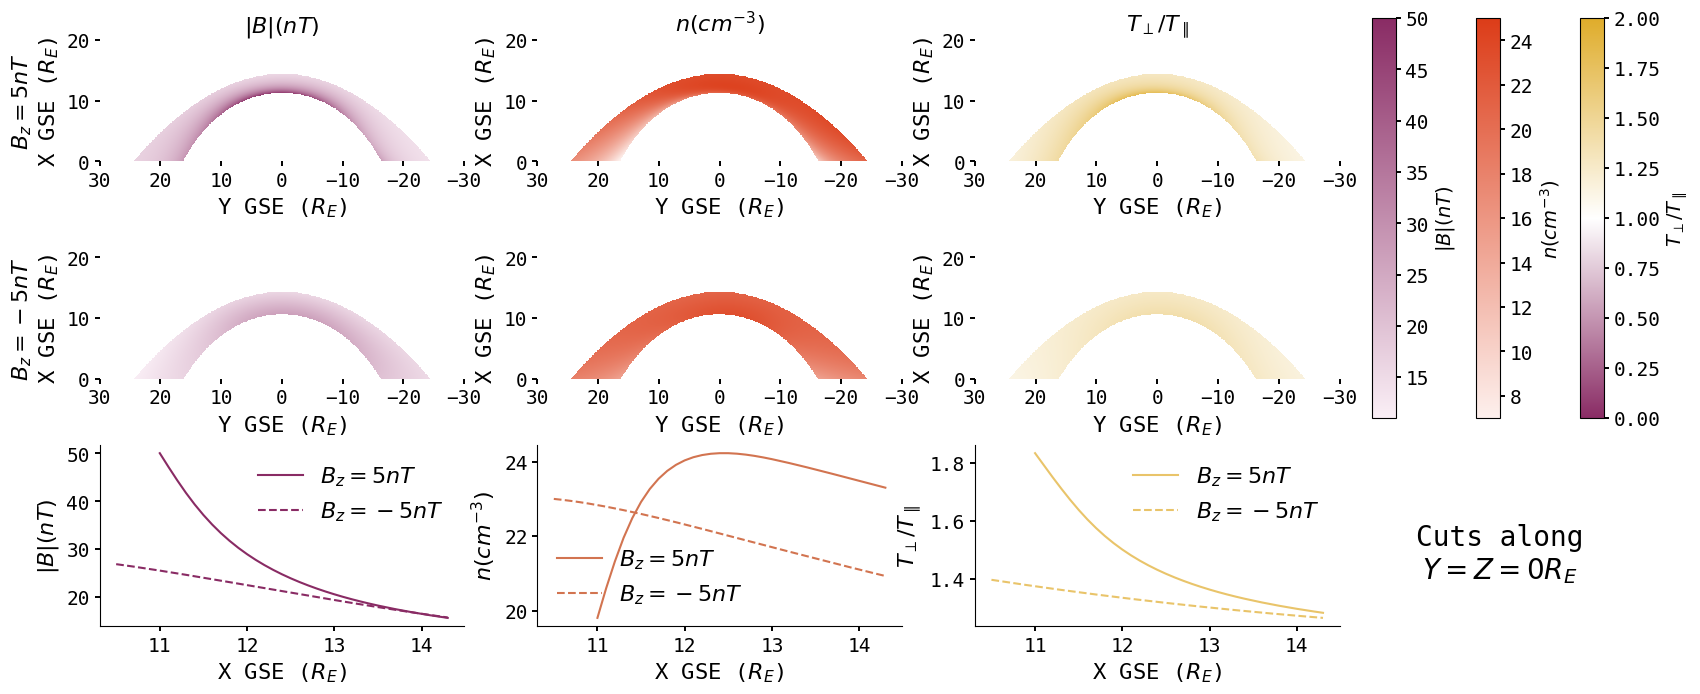

In [70]:
#Plot the Z velocity at each point in the grid for each frame
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16,8))
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
for idx, ax in enumerate(axes.flatten()):
    if (idx == 0)|(idx==3): #B magnitude in first column
        B = np.sqrt(radial_grid[idx//3,:,:,0]**2+radial_grid[idx//3,:,:,2]**2+radial_grid[idx//3,:,:,4]**2) #Calculate the magnitude of the magnetic field
        bim = ax.imshow(B, origin='lower', extent=[y_extent[0], y_extent[1], x_extent[0], x_extent[1]], cmap=new_purples, vmin=11, vmax=50)
        ax.set_ylim(x_extent[0], x_extent[1])
        ax.set_xlim(y_extent[1], y_extent[0])
        if (idx==0): #Add +Bz to ylabel on top row
            ax.set_ylabel('$B_{z}=5nT$\nX GSE ($R_{E}$)', fontsize = 16)
        if (idx==3): #Add -Bz to ylabel on top row
            ax.set_ylabel('$B_{z}=-5nT$\nX GSE ($R_{E}$)', fontsize = 16)
        ax.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #If idx is 0, add title
        if (idx==0):
            ax.set_title(r'$|B|(nT)$', fontsize = 16)
    if (idx == 1)|(idx == 4): #n in second column
        nim = ax.imshow(radial_grid[idx//3,:,:,12], origin='lower', extent=[y_extent[0], y_extent[1], x_extent[0], x_extent[1]], cmap=new_oranges, vmin = 7, vmax = 25)
        ax.set_ylim(x_extent[0], x_extent[1])
        ax.set_xlim(y_extent[1], y_extent[0])
        ax.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #If idx is 1, add title
        if (idx==1):
            ax.set_title(r'$n(cm^{-3})$', fontsize = 16)
    if (idx == 2)|(idx == 5): #Tperp/Tpar in third column
        tim = ax.imshow(radial_grid[idx//3,:,:,16]/radial_grid[idx//3,:,:,14], origin='lower', extent=[y_extent[0], y_extent[1], x_extent[0], x_extent[1]], cmap=new_puor, vmin=0, vmax=2)
        ax.set_ylim(x_extent[0], x_extent[1])
        ax.set_xlim(y_extent[1], y_extent[0])
        ax.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #If idx is 2, add title
        if (idx==2):
            ax.set_title(r'$T_{\perp}/T_{\parallel}$', fontsize = 16)
    if (idx == 6): #Plot cuts along y=0 for Bz = 5nT and -5nT for B
        mid_arg = len(y_grid)//2 #Find the middle index of the grid (y=0)
        B_pos = np.sqrt(radial_grid[0,:,mid_arg,0]**2+radial_grid[0,:,mid_arg,2]**2+radial_grid[0,:,mid_arg,4]**2) #Calculate the magnitude of the magnetic field
        ax.plot(x_grid, B_pos, color = c1, label = r'$B_{z}=5nT$')
        B_neg = np.sqrt(radial_grid[1,:,mid_arg,0]**2+radial_grid[1,:,mid_arg,2]**2+radial_grid[1,:,mid_arg,4]**2)
        ax.plot(x_grid, B_neg, color = c1, label = r'$B_{z}=-5nT$', linestyle = '--')
        ax.set_xlabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_ylabel(r'$|B|(nT)$', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(fontsize = 16)
    if (idx == 7):  #Plot cuts along y=0 for Bz = 5nT and -5nT for n
        mid_arg = len(y_grid)//2 #Find the middle index of the grid (y=0)
        ax.plot(x_grid, radial_grid[0,:,mid_arg,12], color = c3, label = r'$B_{z}=5nT$')
        ax.plot(x_grid, radial_grid[1,:,mid_arg,12], color = c3, label = r'$B_{z}=-5nT$', linestyle = '--')
        ax.set_xlabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_ylabel(r'$n(cm^{-3})$', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(fontsize = 16)
    if (idx == 8): #Plot cuts along y=0 for Bz = 5nT and -5nT for Tperp/Tpar
        mid_arg = len(y_grid)//2 #Find the middle index of the grid (y=0)
        ax.plot(x_grid, radial_grid[0,:,mid_arg,16]/radial_grid[0,:,mid_arg,14], color = c5, label = r'$B_{z}=5nT$')
        ax.plot(x_grid, radial_grid[1,:,mid_arg,16]/radial_grid[1,:,mid_arg,14], color = c5, label = r'$B_{z}=-5nT$', linestyle = '--')
        ax.set_xlabel(r'X GSE ($R_{E}$)', fontsize = 16)
        ax.set_ylabel(r'$T_{\perp}/T_{\parallel}$', fontsize = 16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(fontsize = 16)
#Put text to the right of the last plot
fig.text(1, 0.2, 'Cuts along\n$Y=Z=0R_{E}$', ha='center', va='center', fontsize = 20)
#Add colorbar for B magnitude
cbar_b = pr.colorbar_maker(fig, bim, label='$|B|(nT)$', box = [0.92, 0.37, 0.015, 0.5])
#Add colorbar for n
cbar_n = pr.colorbar_maker(fig, nim, label='$n(cm^{-3})$', box = [0.92+0.065, 0.37, 0.015, 0.5])
#Add colorbar for Tperp/Tpar
cbar_t = pr.colorbar_maker(fig, tim, label='$T_{\perp}/T_{\parallel}$', box = [0.92+0.13, 0.37, 0.015, 0.5])
#plt.savefig(plotpath+'sheath_grid_bz.pdf', bbox_inches='tight')

In [ ]:
#Make a "Brazil Plot" (please find a better name for this) for sheath outputs
R_predict = predict_test['Tiperp']/predict_test['Tipar']
beta_predict = 0.403*predict_test['Ni']*predict_test['Tipar']/(np.sqrt(predict_test['B_xgsm']**2+predict_test['B_xgsm']**2+predict_test['B_xgsm']**2)**2)
R_observed = mms_test['Tiperp']/mms_test['Tipar']
beta_observed = 0.403*mms_test['Ni']*mms_test['Tipar']/(np.sqrt(mms_test['B_xgsm']**2+mms_test['B_xgsm']**2+mms_test['B_xgsm']**2)**2)

#2D histogram with logscale x axis
xmin = 0 # <- minimum value on x-axis (Note: 10**xmin)
xmax = 3
ymin = 0.7
ymax = 1.6
nbins = 30
xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
ybins = np.linspace(ymin, ymax, nbins) # <- make a range from ymin to ymax

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,8))
counts_predict, xedges, yedges = np.histogram2d(beta_predict, R_predict, bins=[xbins, ybins])
counts_observed, xedges, yedges = np.histogram2d(beta_observed, R_observed, bins=[xbins, ybins])
pcm0 = ax[0].pcolormesh(xbins, ybins, counts_predict.T, norm = LogNorm(), cmap=new_oranges)
ax[0].set_xscale("log")
ax[0].set_xlabel(r'$\beta_{\parallel}$', fontsize = 16)
ax[0].set_ylabel(r'$T_{\perp}/T_{\parallel}$', fontsize = 16)
ax[0].set_title('Sheath Parameter Distribution (PRIME-SH)', fontsize = 16)
pcm1 = ax[1].pcolormesh(xbins, ybins, counts_observed.T, norm = LogNorm(), cmap=new_oranges)
ax[1].set_xscale("log")
ax[1].set_xlabel(r'$\beta_{\parallel}$', fontsize = 16)
ax[1].set_ylabel(r'$T_{\perp}/T_{\parallel}$', fontsize = 16)
ax[1].set_title('Sheath Parameter Distribution (Observed)', fontsize = 16)
pr.colorbar_maker(fig, pcm1, label=r'Counts', box = [0.92, 0.1, 0.015, 0.75])
# plt.savefig(plotpath+'sheath_brazil.pdf', bbox_inches='tight')

In [8]:
#Construct frames of synthetic 
x_extent = [0, 20]
y_extent = [0,0.1]
gridsize = 0.1
ni = np.arange(1,50, 2)
framenum = len(ni)
bx = -4*np.ones(framenum)
by = -4*np.ones(framenum)
bz = np.zeros(framenum)

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 30, vz = 0, ni = ni, vt = 34.9,
                                   rx = 200, ry = 0, rz = 0, loc_mask = True, subtract_ecliptic = True)

/tmp/ipykernel_308/1088733255.py:5: RuntimeWarning: invalid value encountered in sqrt
  nv_down_grid = radial_grid[:,:,0,12] * np.sqrt(radial_grid[:,:,0,6]**2 + radial_grid[:,:,0,8]**2 + radial_grid[:,:,0,10]**2) #Calculate the downstream particle flux


Text(0.5, 1.0, 'Condition 3 (Energy)')

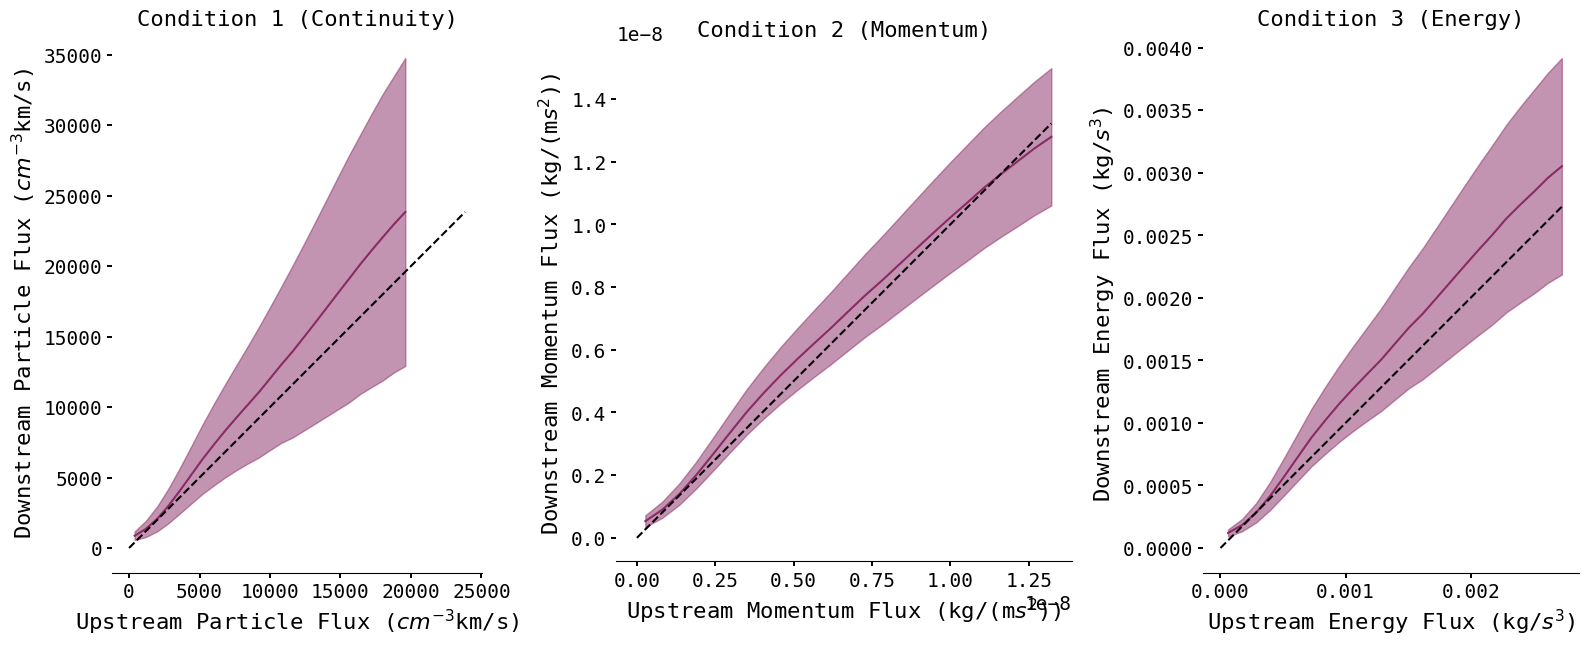

In [9]:
#RH Jump Condition 1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

nv_up = ni * 400 #Calculate the upstream particle flux
nv_down_grid = radial_grid[:,:,0,12] * np.sqrt(radial_grid[:,:,0,6]**2 + radial_grid[:,:,0,8]**2 + radial_grid[:,:,0,10]**2) #Calculate the downstream particle flux
nv_down = np.zeros(framenum)
nv_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,0,12] that is not masked and assign it to nv_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,0,12])[1]
    nv_down[i] = radial_grid[i,arg,0,12] * np.sqrt(radial_grid[i,arg,0,6]**2 + radial_grid[i,arg,0,8]**2 + radial_grid[i,arg,0,10]**2)
    nv_down_err[i] = radial_grid[i,arg,0,12] * np.sqrt(radial_grid[i,arg,0,7]**2 + radial_grid[i,arg,0,9]**2 + radial_grid[i,arg,0,11]**2)
#Plot the upstream and downstream particle fluxes
axes[0].plot(nv_up, nv_down, color = c1, label = 'Upstream')
axes[0].fill_between(nv_up, nv_down - nv_down_err, nv_down + nv_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[0].plot(np.linspace(0, np.max(nv_down)), np.linspace(0, np.max(nv_down)), color = 'k', linestyle = '--')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'Upstream Particle Flux ($cm^{-3}$km/s)', fontsize = 16)
axes[0].set_ylabel(r'Downstream Particle Flux ($cm^{-3}$km/s)', fontsize = 16)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_title(r'Condition 1 (Continuity)', fontsize = 16)

#RH Jump condition 2
vth = wind_data['Vth'].mean() #Set the upstream thermal velocity to the mean of the dataset
nv2p_up = (1.673e-15) * ni * 400**2 + (1.673e-15) * ni * vth**2 + (3.979e-13) * np.abs(bx**2+by**2) - (2*3.979e-13) * (bx**2) #Calculate the upstream momentum flux in kg/ms^2
nv2p_down = np.zeros(framenum)
nv2p_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,0,12] that is not masked and assign it to nv2p_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,0,12])[1]
    v_down = np.sqrt(radial_grid[i,arg,0,6]**2 + radial_grid[i,arg,0,8]**2 + radial_grid[i,arg,0,10]**2) #Calculate the downstream velocity magnitude
    b_down = np.sqrt(radial_grid[i,arg,0,0]**2 + radial_grid[i,arg,0,2]**2 + radial_grid[i,arg,0,4]**2) #Calculate the downstream magnetic field magnitude
    nv2p_down[i] = (1.673e-15) * radial_grid[i,arg,0,12] * v_down**2 + (1.602e-13) * radial_grid[i,arg,0,12] * radial_grid[i,arg,0,16] - (3.979e-13) * (radial_grid[i,arg,0,0]**2)
    nv2p_down_err[i] = (1.673e-15) * radial_grid[i,arg,0,13] * v_down**2 + (1.602e-13) * radial_grid[i,arg,0,13] * radial_grid[i,arg,0,16] + (3.979e-13) * (b_down**2) - (2*3.979e-13) * (radial_grid[i,arg,0,1]**2)
#Plot the upstream and downstream momentum fluxes
axes[1].plot(nv2p_up, nv2p_down, color = c1, label = 'Upstream')
axes[1].fill_between(nv2p_up, nv2p_down - nv2p_down_err, nv2p_down + nv2p_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[1].plot(np.linspace(0, np.max(nv2p_up)), np.linspace(0, np.max(nv2p_up)), color = 'k', linestyle = '--')
axes[1].set_aspect('equal')
axes[1].set_xlabel(r'Upstream Momentum Flux (kg/(m$s^{2}$))', fontsize = 16)
axes[1].set_ylabel(r'Downstream Momentum Flux (kg/(m$s^{2}$))', fontsize = 16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_title(r'Condition 2 (Momentum)', fontsize = 16)

#RH Jump condition 3
eng_up = (0.5*1.673e-12) * ni * 400**2 * (-400) + (2.5) * (1.673e-12) * ni * vth**2 * (-400) + (7.958e-10) * np.abs(bx**2+by**2) * (-400) - (7.958e-10) * (bx**2) * (-400)  #Calculate the upstream energy flux in kg/s^3
eng_up = -1*eng_up #Flip the sign of the upstream energy flux to make it more intuitive (since X points away from the earth it's technically negative)
eng_down = np.zeros(framenum)
eng_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,0,12] that is not masked and assign it to eng_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,0,12])[1]
    v_down = np.sqrt(radial_grid[i,arg,0,6]**2 + radial_grid[i,arg,0,8]**2 + radial_grid[i,arg,0,10]**2) #Calculate the downstream velocity magnitude
    b_down = np.sqrt(radial_grid[i,arg,0,0]**2 + radial_grid[i,arg,0,2]**2 + radial_grid[i,arg,0,4]**2) #Calculate the downstream magnetic field magnitude
    eng_down[i] = (0.5*1.673e-12) * radial_grid[i,arg,0,12] * v_down**2 * radial_grid[i,arg,0,6] + (2.5) * (1.602e-10) * radial_grid[i,arg,0,12] * radial_grid[i,arg,0,16] * radial_grid[i,arg,0,6]
    eng_down[i] += (7.958e-10) * b_down**2 * radial_grid[i,arg,0,6] - (7.958e-10) * (radial_grid[i,arg,0,0]**2) * radial_grid[i,arg,0,6]
    eng_down_err[i] = (1.673e-12) * radial_grid[i,arg,0,12] * v_down**2 * radial_grid[i,arg,0,7] + (2.5) * (1.602e-10) * radial_grid[i,arg,0,12] * radial_grid[i,arg,0,16] * radial_grid[i,arg,0,7]
    eng_down_err[i] += (7.958e-10) * b_down**2 * radial_grid[i,arg,0,7] - (7.958e-10) * (radial_grid[i,arg,0,0]**2) * radial_grid[i,arg,0,7]
eng_down = -1*eng_down #Flip the sign of the downstream energy flux to make it more intuitive (since X points away from the earth it's technically negative)
#Plot the upstream and downstream energy fluxes
axes[2].plot(eng_up, eng_down, color = c1, label = 'Upstream')
axes[2].fill_between(eng_up, eng_down - eng_down_err, eng_down + eng_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[2].plot(np.linspace(0, np.max(eng_up)), np.linspace(0, np.max(eng_up)), color = 'k', linestyle = '--')
axes[2].set_aspect('equal')
axes[2].set_xlabel(r'Upstream Energy Flux (kg/$s^{3}$)', fontsize = 16)
axes[2].set_ylabel(r'Downstream Energy Flux (kg/$s^{3}$)', fontsize = 16)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].set_title(r'Condition 3 (Energy)', fontsize = 16)
#plt.savefig(plotpath+'continuity.pdf', bbox_inches='tight')